In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter

import central_system as cs
import analyze_control as ac
import read_load as rl

import report_study_case
import report_external_conditions
import report_system_spec
import report_house_spec
import report_general_property
import report_occupant_usage
import report_circulating_air_flow

Importing Jupyter notebook from report_study_case.ipynb
Importing Jupyter notebook from report_external_conditions.ipynb
Importing Jupyter notebook from report_system_spec.ipynb
Importing Jupyter notebook from report_house_spec.ipynb
Importing Jupyter notebook from report_general_property.ipynb
Importing Jupyter notebook from report_occupant_usage.ipynb
Importing Jupyter notebook from report_circulating_air_flow.ipynb


# 0. 検討ケース

試算するケースを取得します。

In [2]:
case = report_study_case.get_case()
case

{'region': 6,
 'house': {'a_mr': 29.81,
  'a_or': 51.34,
  'a_a': 120.08,
  'r_env': 2.9555555555555557,
  'insulation': 'h11',
  'solar_gain': 'middle'},
 'system': {'default_heat_source_spec': True,
  'v_hs_rtd_h': 1800.0,
  'v_hs_rtd_c': 1800.0,
  'is_duct_insulated': True,
  'vav_system': False,
  'cap_rtd_h': None,
  'cap_rtd_c': None}}

1日グラフを描画する日を取得します。

In [3]:
hday, cday = report_study_case.get_display_day()
hday, cday

('2/23', '9/1')

## 1. 外部モジュールの読み込み

### 熱源機の仕様

外部モジュール report_external_conditions を参照のこと。

$q_{rtd,H}$：定格暖房能力, W  
$q_{rtd,C}$：定格冷房能力, W  
$V_{hs,rtd,H}$：熱源機の暖房時の定格風量, m<sup>3</sup>/h  
$V_{hs,rtd,C}$：熱源機の冷房時の定格風量, m<sup>3</sup>/h  

In [4]:
q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system = \
    report_system_spec.get_system_spec(case['region'], case['house']['a_a'], case['system'])

q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system

(7733.9925600000015, 7664.646360000001, 1800.0, 1800.0, True, False)

### 住宅の仕様

外部モジュール report_external_conditions を参照のこと。  

$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [5]:
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent = \
    report_house_spec.get_house_spec(case['region'], case['house'])
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent

(2.9555555555555557,
 120.08,
 29.81,
 51.34,
 38.92999999999999,
 array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
         4.97, 10.77,  1.66]),
 array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933]),
 2.1739130434782608,
 2.7,
 0.101,
 0.062,
 array([60., 20., 40., 20., 20.]))

### 物性値

外部モジュール report_general_property を参照のこと。

$\rho$：空気の密度, kg/m<sup>3</sup>  
$c$：空気の比熱, J/kgK  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
「平日」「休日」の別

In [6]:
rho, c, l_wtr, calender = report_general_property.get_general_property()
rho, c, l_wtr, calender

(1.2,
 1006.0,
 2434.5296000000003,
 array(['休日', '休日', '休日', ..., '休日', '休日', '休日'], dtype=object))

### 気候条件

外部モジュール report_external_conditions を参照のこと。

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  
$x_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$h_{ex_d,t}$：日付$d$の時刻$t$における相対湿度, %  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, ℃  

In [7]:
theta_ex, x_ex, h_ex, j, theta_sat = report_external_conditions.get_external_conditions(case['region'])
theta_ex, x_ex, h_ex, j, theta_sat

(array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([72.52135498, 68.85197153, 69.34240102, ..., 67.88267058,
        69.83672797, 71.8536949 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]))

### 居住者の使い方

外部モジュール report_occupant_usage を参照のこと。

暖房期間  
冷房期間  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱, W  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿, g/h  
$V_{local,d,t}$：日付$d$時刻$t$における局所換気量, m<sup>3</sup>/h  
$\theta_{set,h}$：暖房時の設定温度, ℃  
$\theta_{set,c}$：冷房時の設定温度, ℃  

In [8]:
heating_period, cooling_period, n_p, q_gen, w_gen, v_local, theta_set_h, theta_set_c \
    = report_occupant_usage.get_occupant_usage(case['region'], a_mr, a_or, a_nr, calender)
heating_period, cooling_period, n_p, q_gen, w_gen, v_local, theta_set_h, theta_set_c

(array([ True,  True,  True, ...,  True,  True,  True]),
 array([False, False, False, ..., False, False, False]),
 array([4., 4., 4., ..., 4., 3., 3.]),
 array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 20.0,
 27.0)

### 循環風量

外部モジュール report_circulating_air_flow を参照のこと。

$Q'_{hs,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房時の熱源機の風量を計算するための熱源機の出力, MJ/h  
$Q'_{hs,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房時の熱源機の風量を計算するための熱源機の出力, MJ/h  
$V_{hs,min}$：熱源機の最低風量, m<sup>3</sup>/h  
$Q_{hs,rtd,H}$：熱源機の暖房時の定格出力, m<sup>3</sup>/h  
$Q_{hs,rtd,C}$：熱源機の冷房時の定格出力, m<sup>3</sup>/h  

In [9]:
q_d_hs_h, q_d_hs_c, v_hs_min, q_hs_rtd_h, q_hs_rtd_c, v_d_hs_supply = report_circulating_air_flow.get_circulating_air_flow(
    a_a, q, mu_h, mu_c, v_vent, theta_ex, x_ex, j, heating_period, cooling_period, n_p, q_gen, w_gen, v_local, theta_set_h, theta_set_c,
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c)
q_d_hs_h, q_d_hs_c, v_hs_min, q_hs_rtd_h, q_hs_rtd_c, v_d_hs_supply

(array([18.91793434, 18.56430374, 18.68218061, ..., 16.54683202,
        17.16938059, 21.29112288]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 160.0,
 27.842373216000006,
 27.592726896000002,
 array([1274.32355534, 1253.49364381, 1260.43694765, ..., 1134.65845658,
        1171.32845079, 1414.111539  ]))

# 5. 暖冷房負荷

室 $i$ の暖房負荷 $L_{H,d,t,i}$ 、顕熱冷房負荷 $L_{CS,d,t,i}$ 、潜熱冷房負荷 $L_{CL,d,t,i}$ は、主たる居室・その他の居室の床面積、床面積の合計、断熱性能、日射熱取得性能に応じて決定される。

In [10]:
l_h, l_cs, l_cl = cs.get_load(region=case['region'], insulation=case['house']['insulation'], solar_gain=case['house']['solar_gain'],
                  a_mr=case['house']['a_mr'], a_or=case['house']['a_or'], a_a=case['house']['a_a'], r_env=case['house']['r_env'])

今回使用する居室（room number 1 - 5）の負荷およびその合計、非居室を含めた全部屋の負荷（旧評価方法で使用。新評価方法では非居室の負荷は使用しない。）を描画する。

In [11]:
def make_list(load_data):

    return [(load_data[0], 'room 1'),
            (load_data[1], 'room 2'),
            (load_data[2], 'room 3'),
            (load_data[3], 'room 4'),
            (load_data[4], 'room 5'),
            (np.sum(load_data[0:5], axis=0), 'room 1-5'),
            (np.sum(load_data, axis=0), 'room 1-12')]

#### 年間

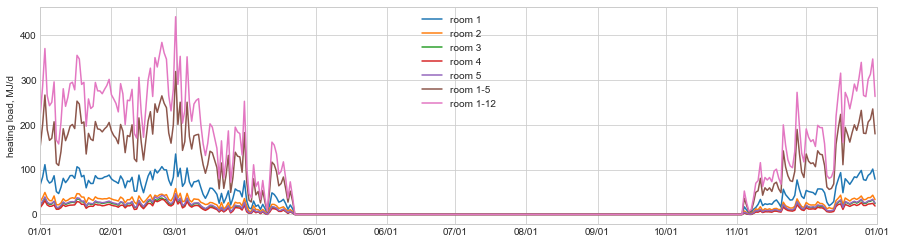

In [12]:
ac.draw_graph('heating load, MJ/d', make_list(l_h), 'itg')

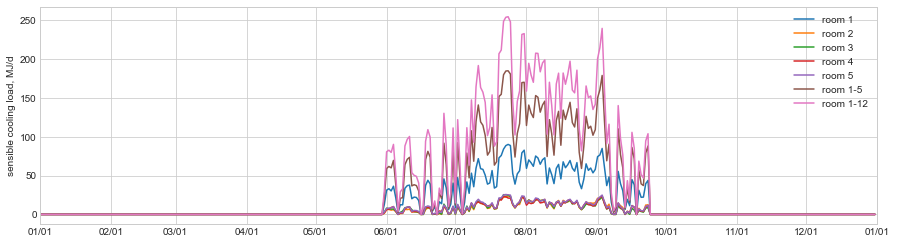

In [13]:
ac.draw_graph('sensible cooling load, MJ/d', make_list(l_cs), 'itg')

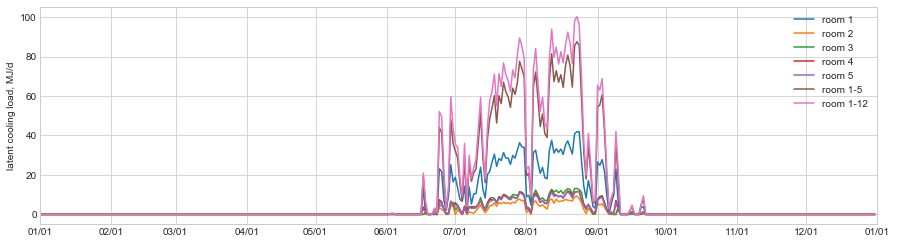

In [14]:
ac.draw_graph('latent cooling load, MJ/d', make_list(l_cl), 'itg')

#### 1日単位

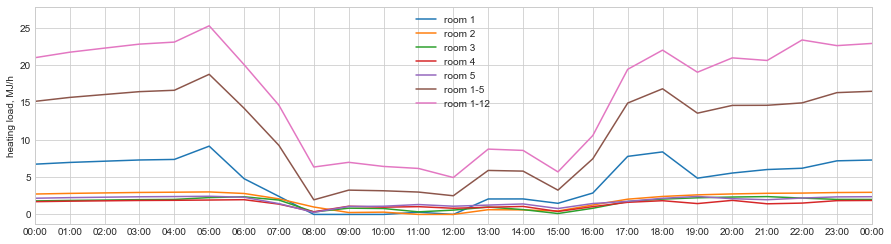

In [15]:
ac.draw_graph(y_title='heating load, MJ/h', ys=make_list(l_h), op='raw', display_date=hday)

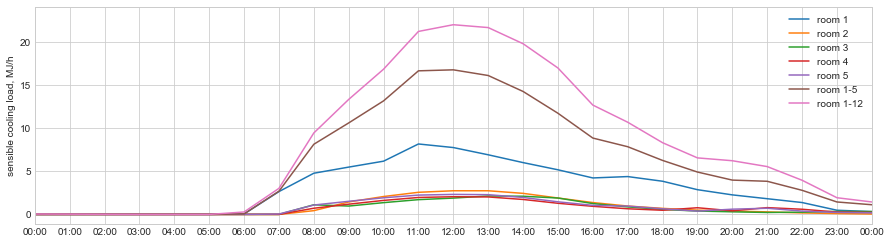

In [16]:
ac.draw_graph(y_title='sensible cooling load, MJ/h', ys=make_list(l_cs), op='raw', display_date=cday)

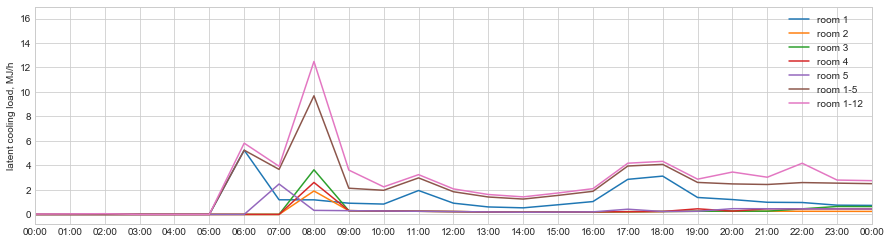

In [17]:
ac.draw_graph(y_title='latent cooling load, MJ/h', ys=make_list(l_cl), op='raw', display_date=cday)

# 6. 運転モード

「暖房時」「冷房時」「非暖冷房時」の定義を記す。  

$ \sum_{i=0}^5{L_{H,d,t,i}} > 0 $ を満たす場合は「暖房時」とする。  
それ以外の場合で、$ \sum_{i=0}^5{L_{CS,d,t,i}} > 0 $ を満たす場合は「冷房時」とする。  
上記いずれにも該当しない場合は「非暖冷房時」とする。

In [18]:
mode = cs.get_operation_mode(l_h, l_cs)

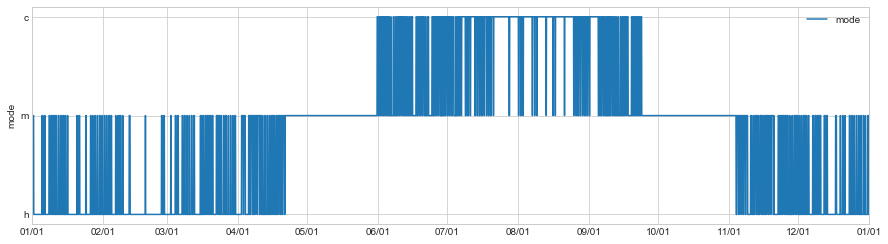

In [19]:
ac.draw_graph('mode', [(mode, 'mode')], 'raw')

# 7. 暖冷房区画の温度（設定温度）

## 設定温度

暖房時の暖冷房区画の温度 $\theta_{ac,H}$ は20℃、冷房時の暖冷房区画の温度 $\theta_{ac,C}$ は27℃とする。

In [20]:
theta_ac_h = cs.get_air_conditioned_temperature_for_heating()
theta_ac_c = cs.get_air_conditioned_temperature_for_cooling()

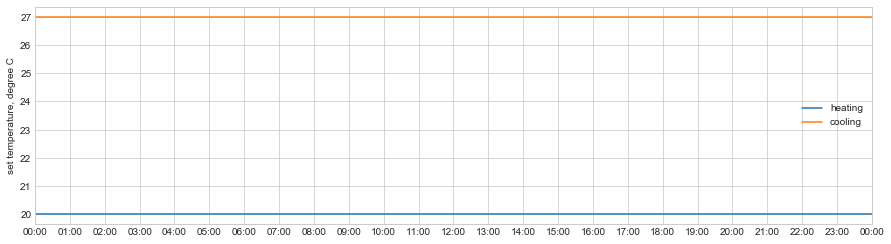

In [21]:
ac.draw_graph(y_title='set temperature, degree C',
              ys=[(theta_ac_h, 'heating'), (theta_ac_c, 'cooling')],
              op='raw', display_date=hday)

## 暖冷房区画の温度

暖房時

$$ \theta_{ac,d,t} = \theta_{ac,H} $$

冷房時

$$ \theta_{ac,d,t} = \theta_{ac,C} $$

非暖冷房時

$$ \theta_{ac,d,t} = \left\{
\begin{array}{ll}
\theta_{ex,d,t} & \theta_{ac,C,d,t} \ge \theta_{ex,d,t}, and \theta_{ex,d,t} \ge \theta_{ac,H,d,t} \\
\theta_{ac,C,d,t} & \theta_{ex,d,t} \gt \theta_{ac,C,d,t} \\
\theta_{ac,H,d,t} & \theta_{ac,H,d,t} \gt \theta_{ex,d,t}
\end{array}
\right. $$

$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房区画の温度, ℃  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, ℃  
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, ℃  $\theta_{attic,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の小屋裏の温度, ℃  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  

In [22]:
theta_ac = cs.get_air_conditioned_room_temperature(theta_ex, mode)

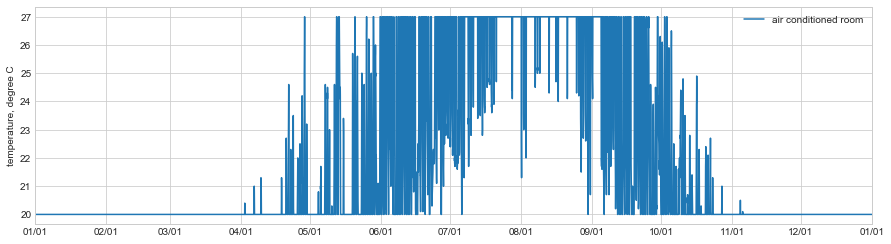

In [23]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_ac, 'air conditioned room')],
              op='raw')

# 8. ダクトおよびダクト周囲温度

## 線熱損失係数

ダクト $i$ の線熱損失係数 $\psi_i$ は、0.49 W/mK とする。

In [24]:
psi = cs.get_duct_linear_heat_loss_coefficient()
psi

0.49

## 標準住戸におけるダクト長さ

標準住戸における断熱区画内を通るダクト $i$ の長さ $l_{duct,in,R,i}$ 、標準住戸における断熱区画外を通るダクト $i$ の長さ $l_{duct,ex,R,i}$ 及び標準住戸におけるダクト $i$ の長さ $l_{duct,R,i}$ は下表の値とする。

| ダクトの長さ, m | 断熱区画1 | 断熱区画2 | 断熱区画3 | 断熱区画4 | 断熱区画5 |
| --- | --- | --- | --- | --- | --- |
| 断熱区画内 | 25.6 | 8.6 | 0.0 | 0.0 | 0.0 |
| 断熱区画外 | 0.0 | 0.0 | 10.2 | 11.8 | 8.1 |
| 合計 | 25.6 | 8.6 | 10.2 | 11.8 | 8.1 |

In [25]:
l_duct_in_r, l_duct_ex_r, l_duct_r = cs.get_standard_house_duct_length()

In [26]:
l_duct_in_r

array([25.6,  8.6,  0. ,  0. ,  0. ])

In [27]:
l_duct_ex_r

array([ 0. ,  0. , 10.2, 11.8,  8.1])

In [28]:
l_duct_r

array([25.6,  8.6, 10.2, 11.8,  8.1])

## 当該住戸のダクト長さ（合計）

ダクト $i$ の長さ $l_{duct,i}$ は次式により表される。

$$ l_{duct,i} = l_{duct,R,i} \sqrt{ \frac{A_A}{A_{A,R}} } $$

$l_{duct,i}$：ダクト$i$の長さ, m  
$l_{duct,R,i}$：標準住戸におけるダクト $i$ の長さ, m  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{A,R}$：標準住戸の床面積の合計, m  

In [29]:
l_duct = cs.get_duct_length(l_duct_r=l_duct_r, a_a=case['house']['a_a'])
l_duct

array([25.6,  8.6, 10.2, 11.8,  8.1])

#### 床面積の合計とダクト長さの関係

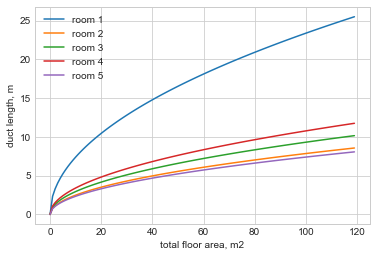

In [30]:
xs = np.arange(120)

def get_duct_length_each_room(room_number):
    return [cs.get_duct_length(l_duct_r=l_duct_r, a_a=x)[room_number] for x in xs]

plt.style.use('seaborn-whitegrid')

fig = plt.figure()

ax = fig.subplots()

ax.plot(xs, get_duct_length_each_room(0), label='room 1')
ax.plot(xs, get_duct_length_each_room(1), label='room 2')
ax.plot(xs, get_duct_length_each_room(2), label='room 3')
ax.plot(xs, get_duct_length_each_room(3), label='room 4')
ax.plot(xs, get_duct_length_each_room(4), label='room 5')

ax.set_xlabel('total floor area, m2')
ax.set_ylabel('duct length, m')

plt.legend()
plt.show()

## 小屋裏温度

$$\theta_{attic,d,t} = \theta_{SAT,d,t} H + \theta_{ac,d,t} ( 1 - H )$$

$\theta_{attic,d,t}$：日付 $d$ の時刻 $t$ における小屋裏の温度, ℃  
$\theta_{SAT,d,t}$：日付 $d$ の時刻 $t$ における水平面における等価外気温度, ℃  
$H$：温度差係数  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房区画の温度, ℃  

温度差係数 $H$ は、1.0とする。

In [31]:
theta_attic = cs.get_attic_temperature(theta_sat, theta_ac)

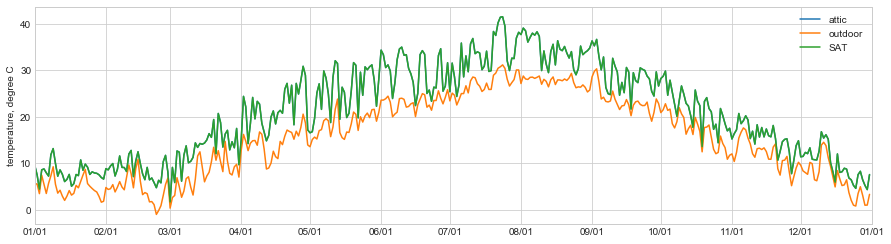

In [32]:
ac.draw_graph(y_title='temperature, degree C', ys=[(theta_attic, 'attic'),(theta_ex, 'outdoor'),(theta_sat, 'SAT')], op='ave')

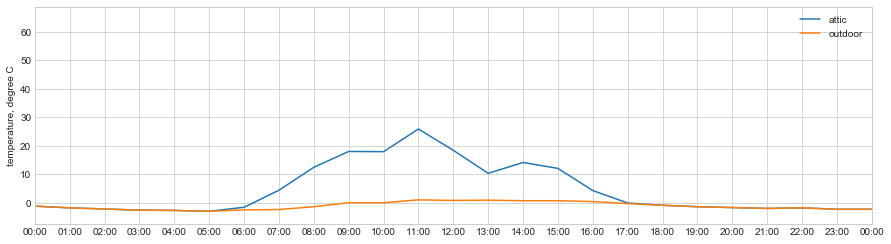

In [33]:
ac.draw_graph(y_title='temperature, degree C', ys=[(theta_attic, 'attic'), (theta_ex, 'outdoor')], op='raw', display_date=hday)

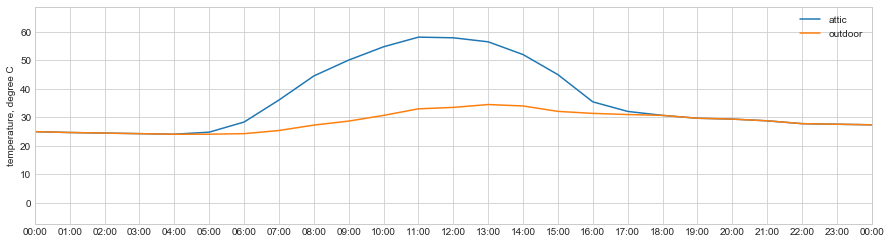

In [34]:
ac.draw_graph(y_title='temperature, degree C', ys=[(theta_attic, 'attic'), (theta_ex, 'outdoor')], op='raw', display_date=cday)

## ダクト周囲空気温度

日付 $d$ の時刻 $t$ におけるダクト $i$ の周囲の空気温度 $\theta_{sur,d,t,i}$ はダクトの全部または一部が断熱区画外にある場合は下式によるものとし、それ意外の場合、暖冷房区画の温度 $\theta_{ac}$ に等しいとする。

$$ \theta_{sur,d,t,i} = \frac{ l_{duct,in,R,i} \theta_{ac} + l_{duct,ex,R,i} \theta_{attic,d,t} }{ l_{duct,in,R,i} + l_{duct,ex,R,i} } $$

$\theta_{sur,d,t,i}$：日付 $d$ の時刻 $t$ におけるダクト $i$ の周囲の空気温度, ℃  
$\theta_{ac}$：暖冷房区画の温度, ℃  
$l_{duct,in,R,i}$：標準住戸における断熱区画内を通るダクト $i$ の長さ, m  
$l_{duct,ex,R,i}$：標準住戸における断熱区画外を通るダクト $i$ の長さ, m  
$\theta_{attic,d,t}$：日付 $d$ の時刻 $t$ における小屋裏の温度, ℃  

In [35]:
theta_sur = cs.get_duct_ambient_air_temperature(case['system']['is_duct_insulated'], l_duct_in_r, l_duct_ex_r, theta_ac, theta_attic)

#### ダクトが全て断熱区画内の場合のサンプル

In [36]:
theta_sur_sample_insulated = cs.get_duct_ambient_air_temperature(True, l_duct_in_r, l_duct_ex_r, theta_ac, theta_attic)

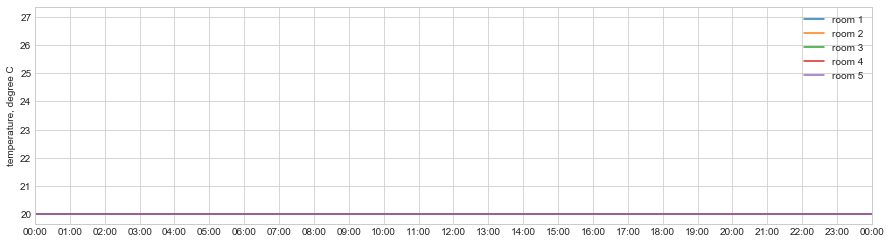

In [37]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_sample_insulated[0], 'room 1'),
                  (theta_sur_sample_insulated[1], 'room 2'),
                  (theta_sur_sample_insulated[2], 'room 3'),
                  (theta_sur_sample_insulated[3], 'room 4'),
                  (theta_sur_sample_insulated[4], 'room 5')], op='raw', display_date=hday)

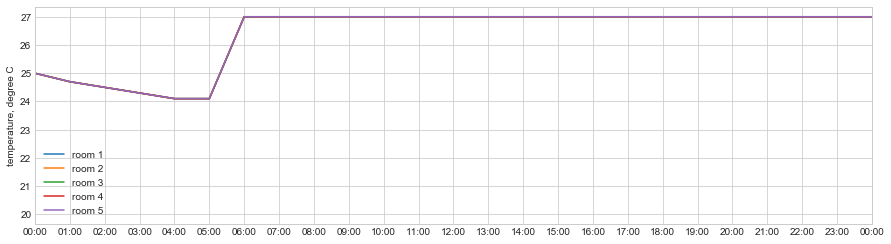

In [38]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_sample_insulated[0], 'room 1'),
                  (theta_sur_sample_insulated[1], 'room 2'),
                  (theta_sur_sample_insulated[2], 'room 3'),
                  (theta_sur_sample_insulated[3], 'room 4'),
                  (theta_sur_sample_insulated[4], 'room 5')], op='raw', display_date=cday)

#### ダクトが全て断熱区画内ではない場合のサンプル

In [39]:
theta_sur_sample_not_insulated = cs.get_duct_ambient_air_temperature(False, l_duct_in_r, l_duct_ex_r, theta_ac, theta_attic)

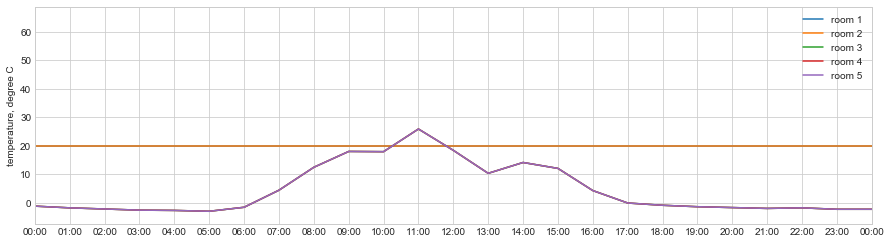

In [40]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_sample_not_insulated[0], 'room 1'),
                  (theta_sur_sample_not_insulated[1], 'room 2'),
                  (theta_sur_sample_not_insulated[2], 'room 3'),
                  (theta_sur_sample_not_insulated[3], 'room 4'),
                  (theta_sur_sample_not_insulated[4], 'room 5')], op='raw', display_date=hday)

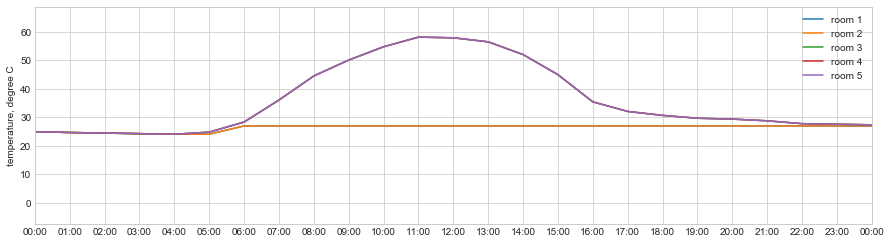

In [41]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_sample_not_insulated[0], 'room 1'),
                  (theta_sur_sample_not_insulated[1], 'room 2'),
                  (theta_sur_sample_not_insulated[2], 'room 3'),
                  (theta_sur_sample_not_insulated[3], 'room 4'),
                  (theta_sur_sample_not_insulated[4], 'room 5')], op='raw', display_date=cday)

# 10. 送風量

## 各室への吹き出し風量バランス（VAV調整前）

$$ r_{supply,des,i} = \frac{ A_{HCZ,i} }{ \sum_{i=1}^5{ A_{HCZ,i} } } $$

$r_{supply,des,i}$：暖冷房区画 $i$ の風量バランス  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  

In [42]:
r_supply_des = cs.get_supply_air_volume_valance(a_hcz)
r_supply_des

array([0.36734442, 0.20406654, 0.16327788, 0.13259396, 0.13271719])

## 各室への吹き出し風量（VAV調整前）

$$ V'_{supply,d,t,i} = \max⁡{ \left( r_{supply,des,i} V'_{hs,supply,H,d,t}, V_{vent,i} \right) } $$    

$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$r_{supply,des,i}$：暖冷房区画 $i$ の風量バランス  
$V'_{hs,supply,d,t}$：日付 $d$ の時刻 $t$ におけるVAV調整前の熱源機の風量, m<sup>3</sup>/h  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [43]:
v_d_supply = cs.get_each_supply_air_volume_not_vav_adjust(r_supply_des, v_d_hs_supply, v_vent)

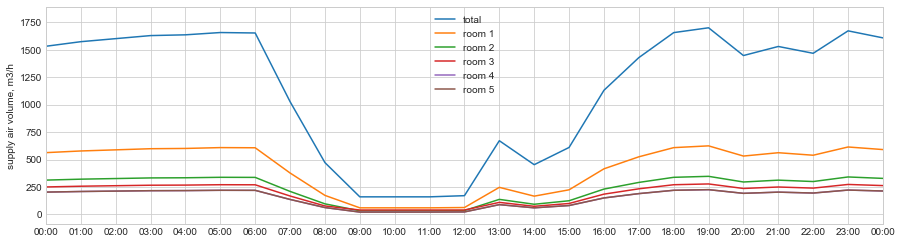

In [44]:
ac.draw_graph(y_title='supply air volume, m3/h',
              ys=[(v_d_hs_supply, 'total'),
                  (v_d_supply[0], 'room 1'),
                  (v_d_supply[1], 'room 2'),
                  (v_d_supply[2], 'room 3'),
                  (v_d_supply[3], 'room 4'),
                  (v_d_supply[4], 'room 5'), ], op='raw', display_date=hday)

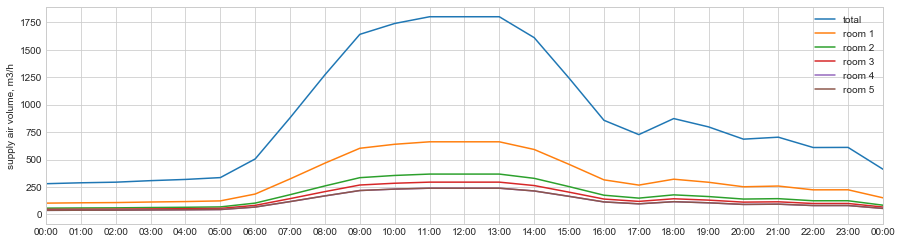

In [45]:
ac.draw_graph(y_title='supply air volume, m3/h',
              ys=[(v_d_hs_supply, 'total'),
                  (v_d_supply[0], 'room 1'),
                  (v_d_supply[1], 'room 2'),
                  (v_d_supply[2], 'room 3'),
                  (v_d_supply[3], 'room 4'),
                  (v_d_supply[4], 'room 5'), ], op='raw', display_date=cday)

# 10. 暖冷房空間（居室）の負荷

## 非暖冷房空間（非居室）の温度（負荷バランス時）

$$ \theta'_{nac,d,t} = \frac{ \left( Q \theta_{ex,d,t} + \mu_{d,t} J_{d,t} \right) A_{NR} + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) } \theta_{ac} }{ Q A_{NR} + \sum_{i=1}^5{ \left( c \rho \frac{ V'_{supply,d,t,i} }{ 3600 } + U_{prt} A_{prt,i} \right) } } $$

ここで、  
暖房期  
$$ \mu_{d,t} = \mu_H$$  
冷房期  
$$ \mu_{d,t} = \mu_C$$  
非暖冷房期  
$$ \mu_{d,t} = \frac{\mu_H + \mu_C}{2}$$  

$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\theta_{ex,d,t}$：日付 $d$ の時刻 $t$ における外気温度, ℃  
$\mu_{d,t}$：日射取得係数, （(W/m<sup>2</sup>)/(W/m<sup>2</sup>)）  
$J_{d,t}$：日付 $d$ の時刻 $t$ における水平面全天日射量, W/m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房区画の温度, ℃  
$\mu_H$：暖房期の日射取得係数, （(W/m<sup>2</sup>)/(W/m<sup>2</sup>)）  
$\mu_C$：冷房期の日射取得係数, （(W/m<sup>2</sup>)/(W/m<sup>2</sup>)）  

※　負荷バランス時：VAV等が導入されており、適切に負荷処理がなされ、暖冷房室の設定温度が過暖房（暖房時）又は過冷房（冷房時）になっていない場合のこと。負荷アンバランス時の場合は室温が設定温度よりも高温（暖房時）又は低温（冷房時）になる影響で非暖冷房室の温度も影響を受ける。（以下、同じ。）

In [46]:
theta_d_nac = cs.get_non_occupant_room_temperature_balanced(
    mode, q, theta_ex, mu_h, mu_c, j, a_nr, v_d_supply, u_prt, a_prt, theta_ac)

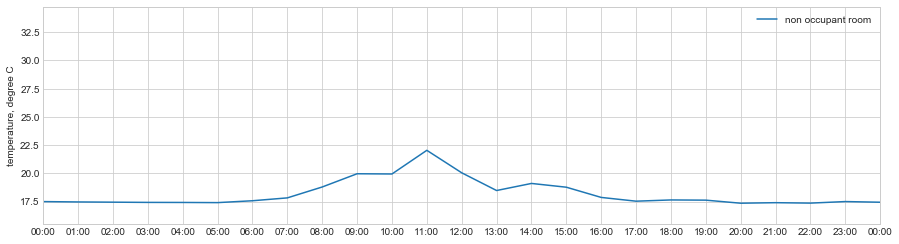

In [47]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_d_nac, 'non occupant room')], op='raw', display_date=hday)

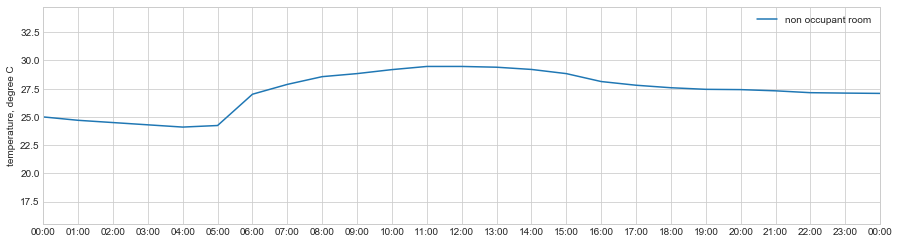

In [48]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_d_nac, 'non occupant room')], op='raw', display_date=cday)

## 暖冷房室（居室）から非暖冷房室（非居室）への熱移動（熱損失（暖房期）・熱取得（冷房期））

$$ Q'_{trs,prt,d,t,i} = U_{prt} A_{prt,i} \left( \theta_{ac,d,t} - \theta'_{nac,d,t} \right) \times 3600 \times 10^{-6} $$

$Q'_{trs,prt,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ から非暖冷房空間への負荷バランス時（※）の熱移動, MJ/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房区画の温度, ℃  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  

※ 同上

In [49]:
q_d_trs_prt = cs.get_heat_transfer_through_partition_balanced(u_prt, a_prt, theta_ac, theta_d_nac)

## 暖冷房室（居室）の負荷

$$ L'_{H,d,t,i} = L_{H,d,t,i} + Q'_{trs,prt,H,d,t,i} $$

$$ L'_{CS,d,t,i} = L_{CS,d,t,i} + Q'_{trs,prt,C,d,t,i} $$

$$ L'_{CL,d,t,i} = L_{CL,d,t,i} $$

ただし、  
$L_{H,d,t,i} = 0$の場合は$L'_{H,d,t,i} = 0$ とする。  
$L'_{H,d,t,i}$が0を下回る場合は0とする。  
$L_{CS,d,t,i} = 0$の場合は$L'_{CS,d,t,i} = 0$ とする。  
$L'_{CS,d,t,i}$が0を下回る場合は0とする。  
$L'_{CL,d,t,i}$が0を下回る場合は0とする。  

$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$L_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの暖房負荷, MJ/h  
$L_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの顕熱冷房負荷, MJ/h  
$L_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの潜熱冷房負荷, MJ/h  
$Q'_{trs,prt,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ から非暖冷房空間への負荷バランス時（※）の貫流熱損失, MJ/h  
$Q'_{trs,prt,C,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房空間から暖冷房区画 $i$ への負荷バランス時（※）の貫流熱取得, MJ/h  

In [50]:
l_d_h = cs.get_occupant_room_load_for_heating_balanced(l_h, q_d_trs_prt)
l_d_cs, l_d_cl = cs.get_occupant_room_load_for_cooling_balanced(l_cs, l_cl, q_d_trs_prt)

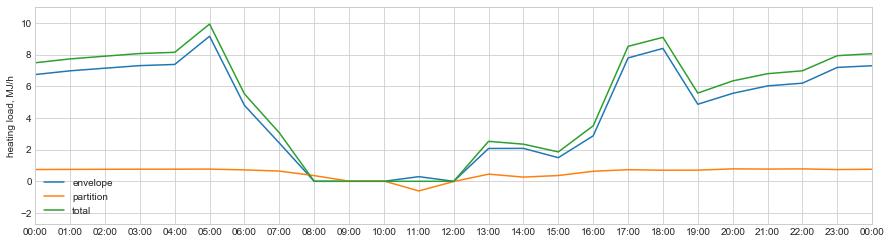

In [51]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[0], 'envelope'), (q_d_trs_prt[0], 'partition'), (l_d_h[0], 'total')], op='raw', display_date=hday)

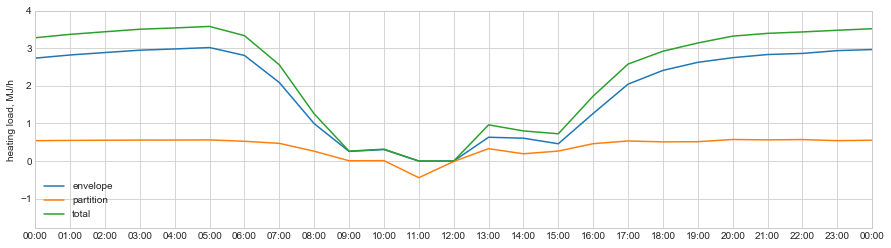

In [52]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[1], 'envelope'), (q_d_trs_prt[1], 'partition'), (l_d_h[1], 'total')], op='raw', display_date=hday)

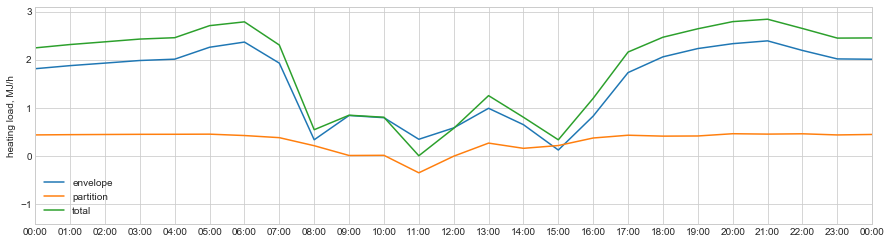

In [53]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[2], 'envelope'), (q_d_trs_prt[2], 'partition'), (l_d_h[2], 'total')], op='raw', display_date=hday)

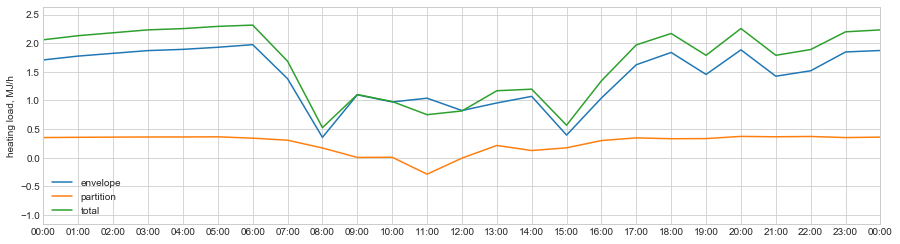

In [54]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[3], 'envelope'), (q_d_trs_prt[3], 'partition'), (l_d_h[3], 'total')], op='raw', display_date=hday)

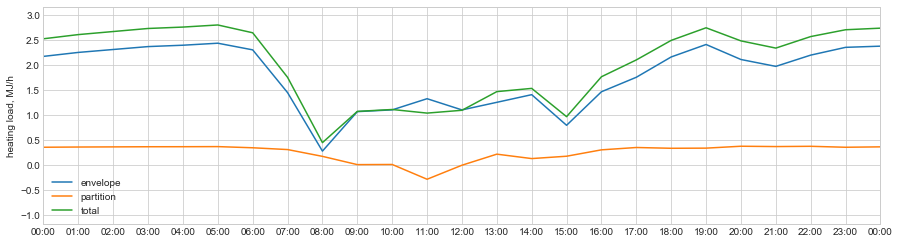

In [55]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[4], 'envelope'), (q_d_trs_prt[4], 'partition'), (l_d_h[4], 'total')], op='raw', display_date=hday)

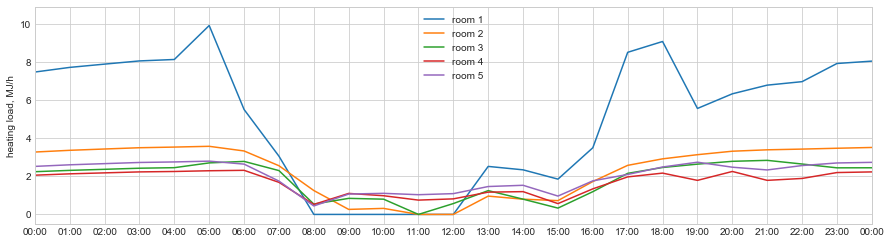

In [56]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[
                  (l_d_h[0], 'room 1'),
                  (l_d_h[1], 'room 2'),
                  (l_d_h[2], 'room 3'),
                  (l_d_h[3], 'room 4'),
                  (l_d_h[4], 'room 5'),
              ], op='raw', display_date=hday)

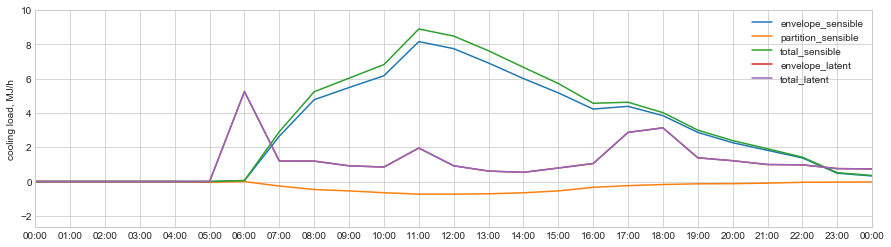

In [57]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[0], 'envelope_sensible'), (q_d_trs_prt[0], 'partition_sensible'), (l_d_cs[0], 'total_sensible'),
                  (l_cl[0], 'envelope_latent'), (l_d_cl[0], 'total_latent')], op='raw', display_date=cday)

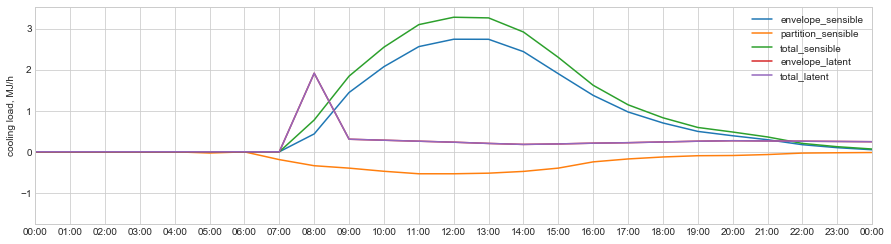

In [58]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[1], 'envelope_sensible'), (q_d_trs_prt[1], 'partition_sensible'), (l_d_cs[1], 'total_sensible'),
                  (l_cl[1], 'envelope_latent'), (l_d_cl[1], 'total_latent')], op='raw', display_date=cday)

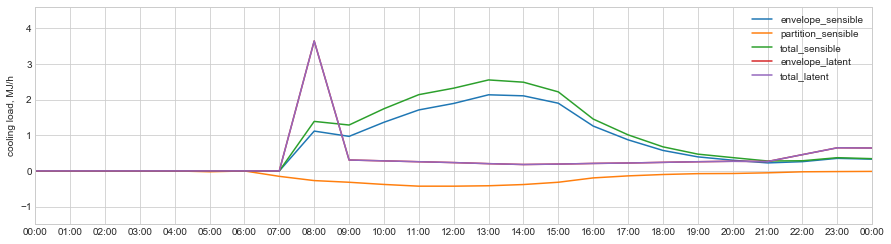

In [59]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[2], 'envelope_sensible'), (q_d_trs_prt[2], 'partition_sensible'), (l_d_cs[2], 'total_sensible'),
                  (l_cl[2], 'envelope_latent'), (l_d_cl[2], 'total_latent')], op='raw', display_date=cday)

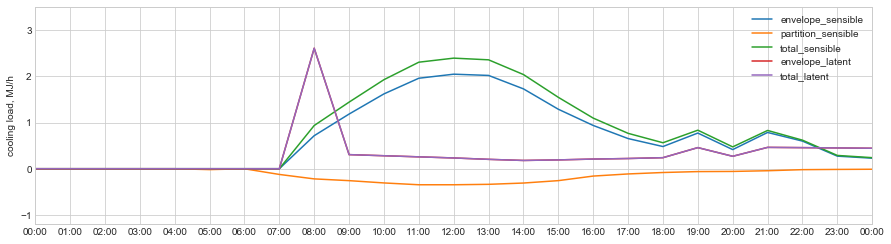

In [60]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[3], 'envelope_sensible'), (q_d_trs_prt[3], 'partition_sensible'), (l_d_cs[3], 'total_sensible'),
                  (l_cl[3], 'envelope_latent'), (l_d_cl[3], 'total_latent')], op='raw', display_date=cday)

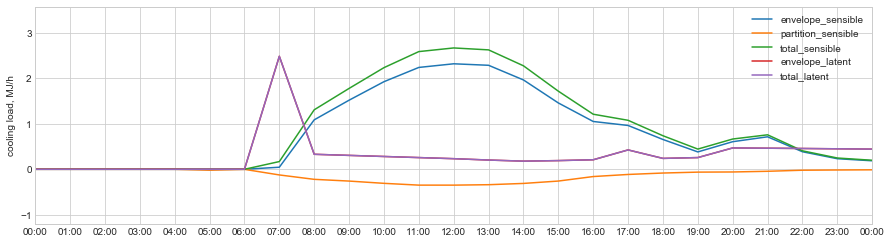

In [61]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[4], 'envelope_sensible'), (q_d_trs_prt[4], 'partition_sensible'), (l_d_cs[4], 'total_sensible'),
                  (l_cl[4], 'envelope_latent'), (l_d_cl[4], 'total_latent')], op='raw', display_date=cday)

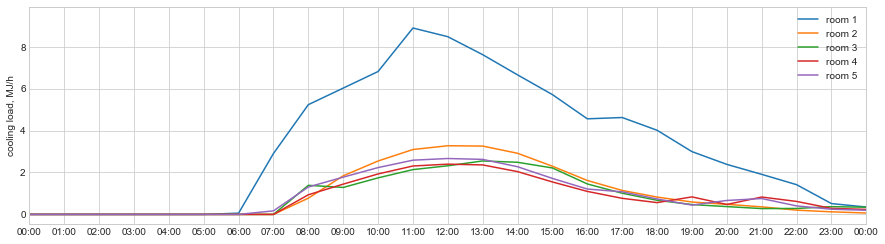

In [62]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[
                  (l_d_cs[0], 'room 1'),
                  (l_d_cs[1], 'room 2'),
                  (l_d_cs[2], 'room 3'),
                  (l_d_cs[3], 'room 4'),
                  (l_d_cs[4], 'room 5'),
              ], op='raw', display_date=cday)

# 11. 処理負荷・未処理負荷

## 熱源機の入口空気温度

$$ \theta'_{hs,in,d,t} = \theta'_{nac,d,t} $$

$\theta'_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の熱源機の入口空気温度, ℃  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  

In [63]:
theta_d_hs_in = cs.get_heat_source_inlet_air_temperature_balanced(theta_d_nac)

## 熱源機の最大出力

### 暖房

$$ Q_{hs,max,H,d,t} = q_{rtd,H} C_{df,H,d,t} \times 3600 \times 10^{-6} $$

$Q_{hs,max,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大暖房出力, MJ/h  
$q_{rtd,H}$：定格暖房能力, W  
$C_{df,H,d,t}$：日付 $d$ の時刻 $t$ におけるデフロストに関する暖房出力補正係数  

日付 $d$ の時刻tにおけるデフロストに関する暖房出力補正係数 $C_{df,H,d,t}$ は、外気温度が5℃未満かつ相対湿度が80％以上の場合にデフロストが入ると仮定し、その場合の値を0.77とし、 それ以外の条件においては1.0とする。

In [64]:
q_hs_max_h = cs.get_heat_source_maximum_heating_output(case['region'], q_rtd_h)

### 冷房

$$ L'_{CS,d,t} = \sum_{i=1}^5{L'_{CS,d,t,i}} $$

$$ L'_{CL,d,t} = \sum_{i=1}^5{L'_{CL,d,t,i}} $$

$$ SHF_{L,min,C} = 0.4 $$

$$ L_{max,CL,d,t} = L'_{CS,d,t} \frac{ 1 - SHF_{L,min,C} }{ SHF_{L,min,C} } $$

$$ L''_{CL,d,t} = \min { \left( L_{max,CL,d,t}, L'_{CL,d,t} \right) } $$

$$ L''_{C,d,t} = L'_{CS,d,t} + L''_{CL,d,t} $$

$$ SHF'_{d,t} = \frac{ L'_{CS,d,t} }{ L''_{C,d,t} } $$

ただし、日付 $d$ の時刻 $t$ における1時間当たりの補正冷房負荷 $L''_{C,d,t}$ が0の場合、 $ SHF'_{d,t} = 0 $ とする。

$$ Q_{hs,max,CS,d,t} = Q_{hs,max,C,d,t} SHF'_{d,t} $$

$$ Q_{hs,max,CL,d,t} = \min { \left( Q_{hs,max,C,d,t} \left( 1 - SHF'_{d,t} \right), L''_{CL,d,t} \right) } $$


$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$L'_{CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$SHF_{L,min,C}$：冷房負荷最小顕熱比  
$L_{max,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの最大冷房潜熱負荷, MJ/h  
$L''_{CL,d,t}$：日付 $d$ の時刻 $t$ における１時間当たりの補正冷房潜熱負荷, MJ/h  
$L''_{C,d,t}$：日付 $d$ の時刻 $t$ における１時間当たりの補正冷房負荷, MJ/h  
$SHF'_{d,t}$：日付 $d$ の時刻 $t$ における冷房負荷補正顕熱比  
$Q_{hs,max,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房顕熱出力, MJ/h  
$Q_{hs,max,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房潜熱出力, MJ/h  
$Q_{hs,max,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房出力, MJ/h  

In [65]:
q_hs_max_cs, q_hs_max_cl = cs.get_heat_source_maximum_cooling_output(q_rtd_c, l_d_cs, l_d_cl)

## 最大出力

### 暖房

$$ \theta_{hs,out,max,H,d,t} = \theta'_{hs,in,d,t} + \frac{ Q_{hs,max,H,d,t} }{ c \rho \sum_{i=1}^5{V'_{supply,d,t,i}} } \times 10^6 $$

ただし、$ \theta_{hs,out,max,H,d,t} > 45 $ の場合、$ \theta_{hs,out,max,H,d,t} = 45 $ とする。

$$ Q_{max,H,d,t,i} = \left( \theta_{sur,d,t,i} - \theta_{ac,H} + \frac{ \theta_{hs,out,max,H,d,t} - \theta_{sur,d,t,i} }{ \exp{ \left( \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V'_{supply,d,t,i} } \right) } } \right) c \rho V'_{supply,d,t,i} \times 10^{-6} $$

ただし、 $Q_{max,H,d,t,i}$ が0を下回る場合は0とする。

### 冷房（顕熱）

$$ \theta_{hs,out,min,C,d,t} = \theta'_{hs,in,d,t} - \frac{ Q_{hs,max,CS,d,t} }{ c \rho \sum_{i=1}^5{V'_{supply,d,t,i}} } \times 10^6 $$

ただし、$ \theta_{hs,out,min,C,d,t} < 15 $ の場合、$ \theta_{hs,out,min,C,d,t} = 15 $ とする。

$$ Q_{max,CS,d,t,i} = \left( \theta_{ac,C} - \theta_{sur,d,t,i} + \frac{ \theta_{sur,d,t,i} - \theta_{hs,out,min,C,d,t} }{ \exp{ \left( \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V'_{supply,d,t,i} } \right) } } \right) c \rho V'_{supply,d,t,i} \times 10^{-6} $$


ただし、 $Q_{max,CS,d,t,i}$ が0を下回る場合は0とする。

### 冷房（潜熱）

$$ Q_{max,CL,d,t,i} = \left\{
\begin{array}{ll}
0 & \left( \sum_{i=1}^5 {L_{CL,d,t,i}} = 0 \right) \\
\frac{ L_{CL,d,t,i} }{ \sum_{i=1}^5 { L_{CL,d,t,i} } } Q_{hs,max,CL,d,t} & \left( \sum_{i=1}^5 {L_{CL,d,t,i}} > 0 \right)
\end{array}
\right. $$

$\theta_{hs,out,max,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度の最高値, ℃  
$\theta_{hs,out,min,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度の最低値, ℃  
$\theta'_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の熱源機の入口空気温度, ℃  
$Q_{hs,max,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大暖房出力, MJ/h  
$Q_{hs,max,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房顕熱出力, MJ/h  
$Q_{hs,max,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房潜熱出力, MJ/h  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$Q_{max,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の最大暖房出力, MJ/h  
$Q_{max,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の最大冷房顕熱出力, MJ/h  
$Q_{max,CL,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の最大冷房潜熱出力, MJ/h  
$\theta_{sur,d,t,i}$：日付 $d$ の時刻 $t$ におけるダクト $i$ の周囲の空気温度, ℃  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, ℃  
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, ℃  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$L_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ の1時間当たりの冷房潜熱負荷, MJ/h  

In [66]:
q_max_h = cs.get_maximum_heating_supply(theta_d_hs_in, q_hs_max_h, v_d_supply, theta_ac_h, psi, l_duct, theta_sur)

In [67]:
q_max_cs, q_max_cl = cs.get_maximum_cooling_supply(
    theta_d_hs_in, l_cl, q_hs_max_cs, q_hs_max_cl, v_d_supply, theta_ac_c, psi, l_duct, theta_sur)

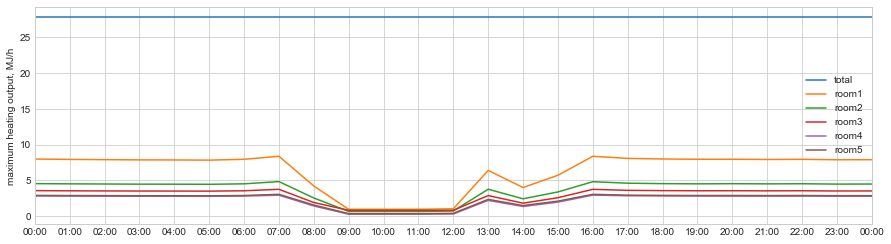

In [68]:
ac.draw_graph(y_title='maximum heating output, MJ/h',
              ys=[(q_hs_max_h, 'total'),
                  (q_max_h[0], 'room1'),
                  (q_max_h[1], 'room2'),
                  (q_max_h[2], 'room3'),
                  (q_max_h[3], 'room4'),
                  (q_max_h[4], 'room5')], op='raw', display_date=hday)

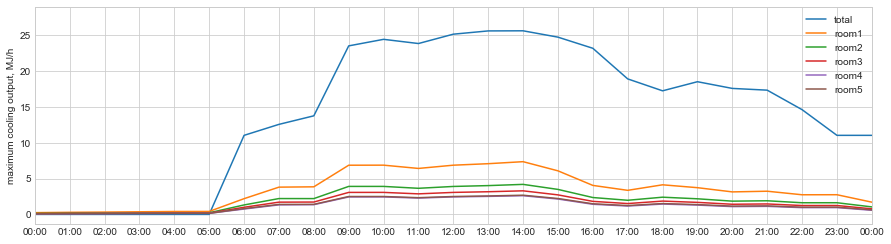

In [69]:
ac.draw_graph(y_title='maximum cooling output, MJ/h',
              ys=[(q_hs_max_cs, 'total'),
                  (q_max_cs[0], 'room1'),
                  (q_max_cs[1], 'room2'),
                  (q_max_cs[2], 'room3'),
                  (q_max_cs[3], 'room4'),
                  (q_max_cs[4], 'room5')], op='raw', display_date=cday)

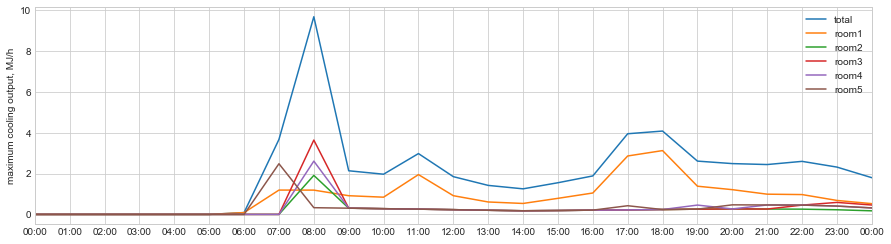

In [70]:
ac.draw_graph(y_title='maximum cooling output, MJ/h',
              ys=[(q_hs_max_cl, 'total'),
                  (q_max_cl[0], 'room1'),
                  (q_max_cl[1], 'room2'),
                  (q_max_cl[2], 'room3'),
                  (q_max_cl[3], 'room4'),
                  (q_max_cl[4], 'room5')], op='raw', display_date=cday)

## 処理負荷・未処理負荷

$$ Q_{T,H,d,t,i} = \min \left( L'_{H,d,t,i}, Q_{max,H,d,t,i} \right) $$

$$ Q_{UT,H,d,t,i} = L'_{H,d,t,i} - Q_{T,H,d,t,i} $$

$$ Q_{T,CS,d,t,i} = \min \left( L'_{CS,d,t,i}, Q_{max,CS,d,t,i} \right) $$

$$ Q_{UT,CS,d,t,i} = L'_{CS,d,t,i} - Q_{T,CS,d,t,i} $$

$$ Q_{T,CL,d,t,i} = \min \left( L'_{CL,d,t,i}, Q_{max,CL,d,t,i} \right) $$

$$ Q_{UT,CL,d,t,i} = L'_{CL,d,t,i} - Q_{T,CL,d,t,i} $$

$Q_{T,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の処理暖房負荷, MJ/h  
$Q_{T,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の処理冷房顕熱負荷, MJ/h  
$Q_{T,CL,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の処理冷房潜熱負荷, MJ/h  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の未処理暖房負荷, MJ/h  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房顕熱負荷, MJ/h  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房潜熱負荷, MJ/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$Q_{max,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の最大暖房出力, MJ/h  
$Q_{max,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の最大冷房顕熱出力, MJ/h  
$Q_{max,CL,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の最大冷房潜熱出力, MJ/h  

In [71]:
q_t_h, q_ut_h = cs.get_treated_untreated_heat_load_for_heating(q_max_h, l_d_h)
q_t_cs, q_t_cl, q_ut_cs, q_ut_cl = cs.get_treated_untreated_heat_load_for_cooling(q_max_cs, q_max_cl, l_d_cs, l_d_cl)

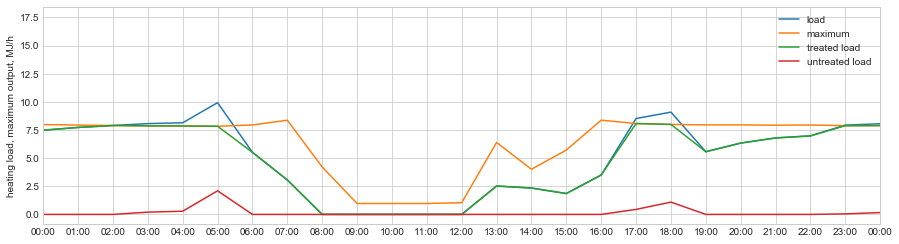

In [72]:
rn = 0
ac.draw_graph(y_title='heating load, maximum output, MJ/h',
              ys=[(l_d_h[rn], 'load'),(q_max_h[rn], 'maximum'), (q_t_h[rn], 'treated load'), (q_ut_h[rn], 'untreated load')],
              op='raw', display_date=hday)

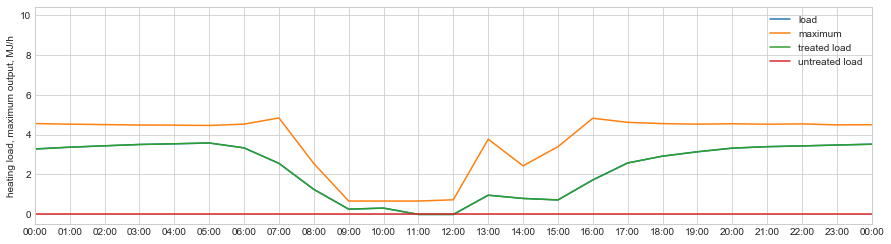

In [73]:
rn = 1
ac.draw_graph(y_title='heating load, maximum output, MJ/h',
              ys=[(l_d_h[rn], 'load'),(q_max_h[rn], 'maximum'), (q_t_h[rn], 'treated load'), (q_ut_h[rn], 'untreated load')],
              op='raw', display_date=hday)

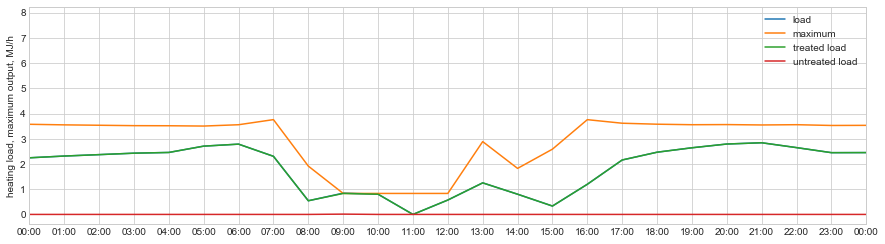

In [74]:
rn = 2
ac.draw_graph(y_title='heating load, maximum output, MJ/h',
              ys=[(l_d_h[rn], 'load'),(q_max_h[rn], 'maximum'), (q_t_h[rn], 'treated load'), (q_ut_h[rn], 'untreated load')],
              op='raw', display_date=hday)

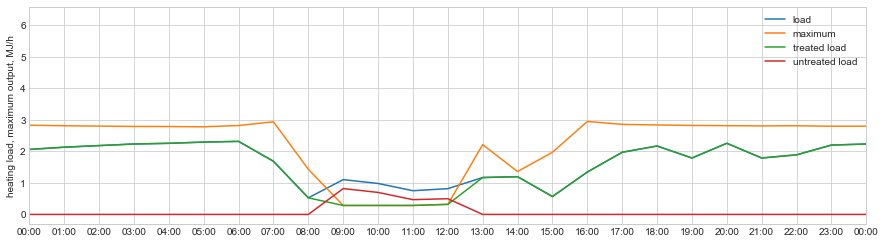

In [75]:
rn = 3
ac.draw_graph(y_title='heating load, maximum output, MJ/h',
              ys=[(l_d_h[rn], 'load'),(q_max_h[rn], 'maximum'), (q_t_h[rn], 'treated load'), (q_ut_h[rn], 'untreated load')],
              op='raw', display_date=hday)

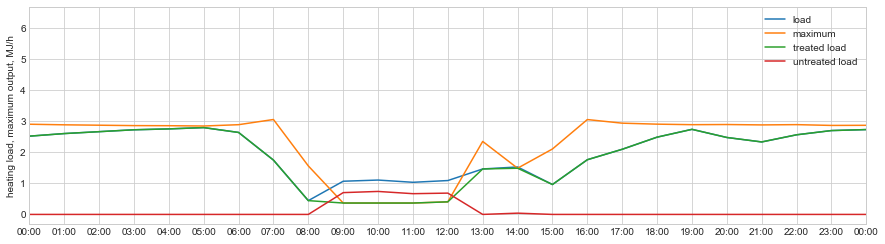

In [76]:
rn = 4
ac.draw_graph(y_title='heating load, maximum output, MJ/h',
              ys=[(l_d_h[rn], 'load'),(q_max_h[rn], 'maximum'), (q_t_h[rn], 'treated load'), (q_ut_h[rn], 'untreated load')],
              op='raw', display_date=hday)

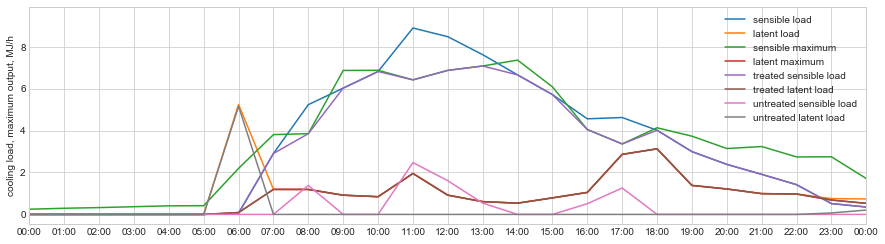

In [77]:
rn = 0
ac.draw_graph(y_title='cooling load, maximum output, MJ/h',
              ys=[(l_d_cs[rn], 'sensible load'), (l_d_cl[rn], 'latent load'),
                  (q_max_cs[rn], 'sensible maximum'), (q_max_cl[rn], 'latent maximum'),
                  (q_t_cs[rn], 'treated sensible load'), (q_t_cl[rn], 'treated latent load'),
                  (q_ut_cs[rn], 'untreated sensible load'), (q_ut_cl[rn], 'untreated latent load')],
              op='raw', display_date=cday)

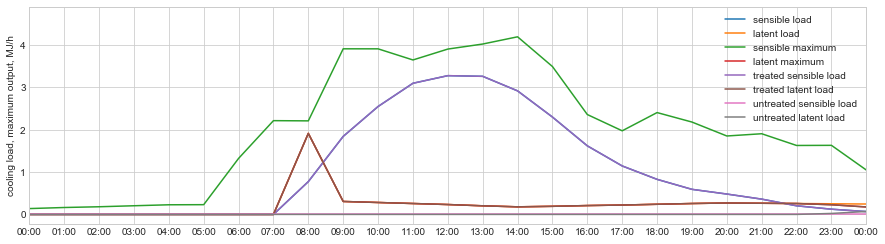

In [78]:
rn = 1
ac.draw_graph(y_title='cooling load, maximum output, MJ/h',
              ys=[(l_d_cs[rn], 'sensible load'), (l_d_cl[rn], 'latent load'),
                  (q_max_cs[rn], 'sensible maximum'), (q_max_cl[rn], 'latent maximum'),
                  (q_t_cs[rn], 'treated sensible load'), (q_t_cl[rn], 'treated latent load'),
                  (q_ut_cs[rn], 'untreated sensible load'), (q_ut_cl[rn], 'untreated latent load')],
              op='raw', display_date=cday)

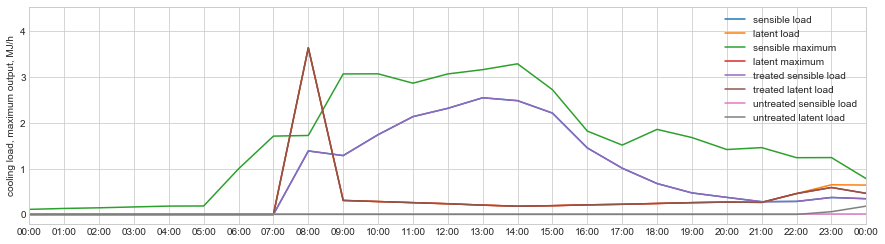

In [79]:
rn = 2
ac.draw_graph(y_title='cooling load, maximum output, MJ/h',
              ys=[(l_d_cs[rn], 'sensible load'), (l_d_cl[rn], 'latent load'),
                  (q_max_cs[rn], 'sensible maximum'), (q_max_cl[rn], 'latent maximum'),
                  (q_t_cs[rn], 'treated sensible load'), (q_t_cl[rn], 'treated latent load'),
                  (q_ut_cs[rn], 'untreated sensible load'), (q_ut_cl[rn], 'untreated latent load')],
              op='raw', display_date=cday)

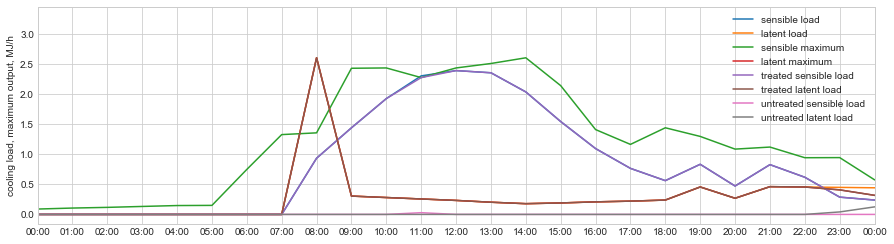

In [80]:
rn = 3
ac.draw_graph(y_title='cooling load, maximum output, MJ/h',
              ys=[(l_d_cs[rn], 'sensible load'), (l_d_cl[rn], 'latent load'),
                  (q_max_cs[rn], 'sensible maximum'), (q_max_cl[rn], 'latent maximum'),
                  (q_t_cs[rn], 'treated sensible load'), (q_t_cl[rn], 'treated latent load'),
                  (q_ut_cs[rn], 'untreated sensible load'), (q_ut_cl[rn], 'untreated latent load')],
              op='raw', display_date=cday)

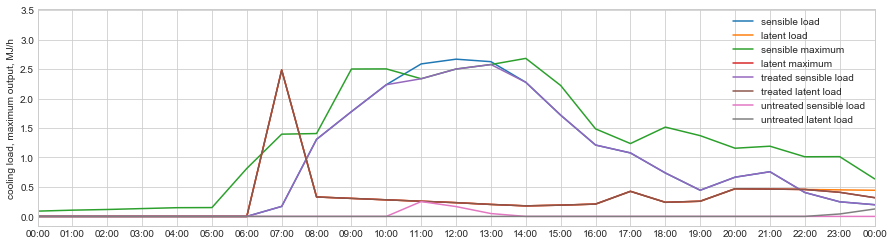

In [81]:
rn = 4
ac.draw_graph(y_title='cooling load, maximum output, MJ/h',
              ys=[(l_d_cs[rn], 'sensible load'), (l_d_cl[rn], 'latent load'),
                  (q_max_cs[rn], 'sensible maximum'), (q_max_cl[rn], 'latent maximum'),
                  (q_t_cs[rn], 'treated sensible load'), (q_t_cl[rn], 'treated latent load'),
                  (q_ut_cs[rn], 'untreated sensible load'), (q_ut_cl[rn], 'untreated latent load')],
              op='raw', display_date=cday)

# 12. 熱源機の出口温度

## 要求温度

$$ \theta_{req,H,d,t,i} = \theta_{sur,H,d,t,i} + \left( \theta_{ac,H} + \frac{ Q_{T,H,d,t,i} \times 10^6 }{ V'_{supply,d,t,i} c \rho } - \theta_{sur,H,d,t,i} \right) \exp{ \left( \frac{ \psi_i l_{duct,i} \times 3600 }{ V'_{supply,d,t,i} c \rho } \right) } $$

$$ \theta_{req,C,d,t,i} = \theta_{sur,C,d,t,i} - \left( \theta_{sur,C,d,t,i} - \theta_{ac,C} + \frac{ Q_{T,CS,d,t,i} \times 10^6 }{ V'_{supply,d,t,i} c \rho } \right) \exp{ \left( \frac{ \psi_i l_{duct,i} \times 3600 }{ V'_{supply,d,t,i} c \rho } \right) } $$

ただし  
$\theta_{req_H,d,t,i}$ が $\theta_{ac_H}$ を下回る場合は、$\theta_{req_H,d,t,i}$ は $\theta_{ac_H}$ に等しいとする。  
$\theta_{req_C,d,t,i}$ が $\theta_{ac_C}$ を上回る場合は、$\theta_{req_C,d,t,i}$ は $\theta_{ac_C}$ に等しいとする。  

$\theta_{req,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房空間 $i$ における熱源機の要求出口空気温度, ℃  
$\theta_{req,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房空間 $i$ における熱源機の要求出口空気温度, ℃  
$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{sur,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, ℃  
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, ℃  
$Q_{T,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の処理暖房負荷, MJ/h  
$Q_{T,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の処理冷房顕熱負荷, MJ/h  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  

In [82]:
theta_req_h = cs.get_requested_supply_air_temperature_for_heating(theta_sur, theta_ac_h, q_t_h, v_d_supply, c, rho, psi, l_duct)
theta_req_c = cs.get_requested_supply_air_temperature_for_cooling(theta_sur, theta_ac_c, q_t_cs, v_d_supply, c, rho, psi, l_duct)

## 決定温度

$$ \theta_{hs,out,H,d,t} = \max_{i=1\sim5}⁡(\theta_{duct,up,H,d,t,i} ) $$

$$ \theta_{hs,out,C,d,t} = \min_{i=1\sim5}(\theta_{duct,up,C,d,t,i} ) $$

$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  

In [83]:
theta_hs_out_h = cs.get_decided_outlet_supply_air_temperature_for_heating(case['system']['vav_system'], theta_req_h, r_supply_des)
theta_hs_out_c = cs.get_decided_outlet_supply_air_temperature_for_cooling(case['system']['vav_system'], theta_req_c, r_supply_des)

In [84]:
theta_hs_out_h_sample_nonvav = cs.get_decided_outlet_supply_air_temperature_for_heating(False, theta_req_h, r_supply_des)
theta_hs_out_h_sample_vav = cs.get_decided_outlet_supply_air_temperature_for_heating(True, theta_req_h, r_supply_des)
theta_hs_out_c_sample_nonvav = cs.get_decided_outlet_supply_air_temperature_for_cooling(False, theta_req_c, r_supply_des)
theta_hs_out_c_sample_vav = cs.get_decided_outlet_supply_air_temperature_for_cooling(True, theta_req_c, r_supply_des)

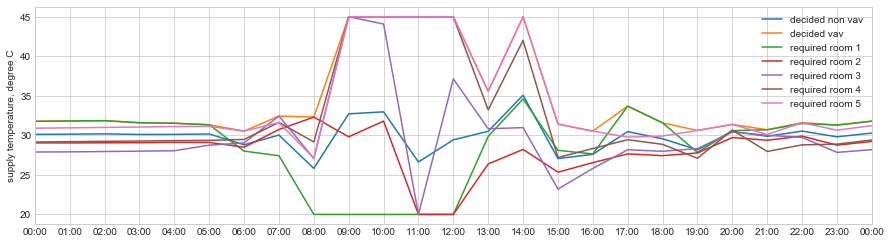

In [85]:
ac.draw_graph(y_title='supply temperature, degree C',
              ys=[(theta_hs_out_h_sample_nonvav, 'decided non vav'),
                  (theta_hs_out_h_sample_vav, 'decided vav'),
                  (theta_req_h[0], 'required room 1'),
                  (theta_req_h[1], 'required room 2'),
                  (theta_req_h[2], 'required room 3'),
                  (theta_req_h[3], 'required room 4'),
                  (theta_req_h[4], 'required room 5')],
              op='raw', display_date=hday)

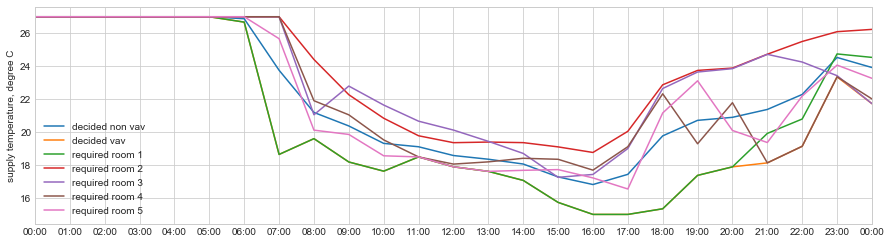

In [86]:
ac.draw_graph(y_title='supply temperature, degree C',
              ys=[(theta_hs_out_c_sample_nonvav, 'decided non vav'),
                  (theta_hs_out_c_sample_vav, 'decided vav'),
                  (theta_req_c[0], 'required room 1'),
                  (theta_req_c[1], 'required room 2'),
                  (theta_req_c[2], 'required room 3'),
                  (theta_req_c[3], 'required room 4'),
                  (theta_req_c[4], 'required room 5')],
              op='raw', display_date=cday)

# 13. 各室への供給風量の決定

熱源機出口温度は各室の要求温度の最高値（暖房時）又は最低値（冷房時）になっているため、暖冷房空間によっては過剰供給になっている場合がある。  
VAVの機構を有する場合は各暖冷房空間の負荷に応じてダンパー等で風量を絞ることによって過剰供給にならないようにすることができる。  
ここでは、その計算を行う。

VAVの機構を有する場合

$$ V_{supply,H,d,t,i} = \frac{ Q_{T,H,d,t,i} \times 10^6 + ( \theta_{hs,out,H,d,t} - \theta_{sur,H,d,t,i} ) \psi_i l_{duct,i} \times 3600 }{ c \rho ( \theta_{hs,out,H,d,t} - \theta_{ac,H} ) } $$

ただし、上限値 $V'_{supply,H,d,t,i}$ 及び、下限値 $V_{vent,i}$ とする。
また、$\theta_{hs,out,H,d,t} = \theta_{ac,H}$ の場合、$V_{supply,H,d,t,i}$ は $V_{vent,i}$ に等しいとする。

$$ V_{supply,C,d,t,i} = \frac{ Q_{T,CS,d,t,i} \times 10^6 + ( \theta_{sur,C,d,t,i} - \theta_{hs,out,C,d,t} ) \psi_i l_{duct,i} \times 3600 }{ c \rho ( \theta_{ac,C} - \theta_{hs,out,C,d,t} ) } $$

ただし、上限値 $V'_{supply,C,d,t,i}$ 及び、下限値 $V_{vent,i}$ とする。
また、$\theta_{hs,out,C,d,t} = \theta_{ac,C}$ の場合、$V_{supply,C,d,t,i}$ は $V_{vent,i}$ に等しいとする。

VAVの機構を有しない場合

$$ V_{supply,H,d,t,i} = V'_{supply,d,t,i} $$  

$$ V_{supply,C,d,t,i} = V'_{supply,d,t,i} $$

$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$Q_{T,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の処理暖房負荷, MJ/h  
$Q_{T,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の処理冷房顕熱負荷, MJ/h  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{sur,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の周囲の空気温度, ℃  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  

In [87]:
v_supply_h = cs.get_each_supply_air_volume_for_heating(
    case['system']['vav_system'], q_t_h, theta_hs_out_h, theta_sur, psi, l_duct, c, rho, theta_ac_h, v_vent, v_d_supply)

In [88]:
v_supply_c = cs.get_each_supply_air_volume_for_cooling(
    case['system']['vav_system'], q_t_cs, theta_hs_out_c, theta_sur, psi, l_duct, c, rho, theta_ac_c, v_vent, v_d_supply)

#### VAVの有無が吹き出し温度に与える影響のサンプル

In [89]:
v_supply_h_sample_nonvav = cs.get_each_supply_air_volume_for_heating(
    False, q_t_h, theta_hs_out_h_sample_nonvav, theta_sur, psi, l_duct, c, rho, theta_ac_h, v_vent, v_d_supply)
v_supply_h_sample_vav = cs.get_each_supply_air_volume_for_heating(
    True, q_t_h, theta_hs_out_h_sample_vav, theta_sur, psi, l_duct, c, rho, theta_ac_h, v_vent, v_d_supply)

In [90]:
def draw_v_supply_h_sample_graph(rn):
    ac.draw_graph(y_title='supply air volume m3/h',
                  ys=[(v_d_supply[rn], 'designed'),
                      (v_supply_h_sample_nonvav[rn], 'non vav'),
                      (v_supply_h_sample_vav[rn], 'vav')],
                  op='raw', display_date=hday)

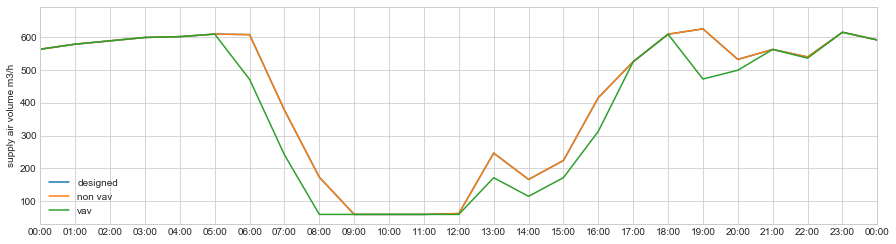

In [91]:
draw_v_supply_h_sample_graph(0)

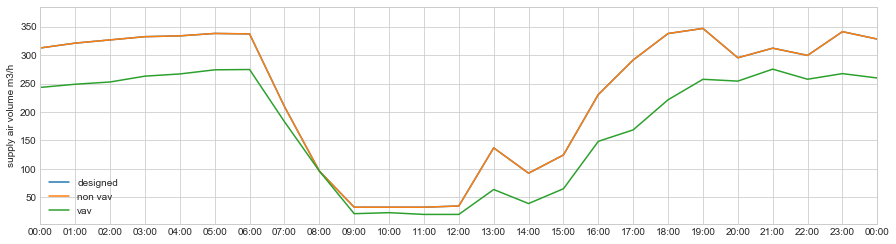

In [92]:
draw_v_supply_h_sample_graph(1)

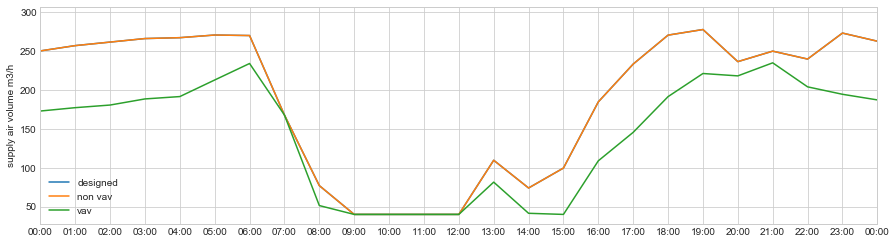

In [93]:
draw_v_supply_h_sample_graph(2)

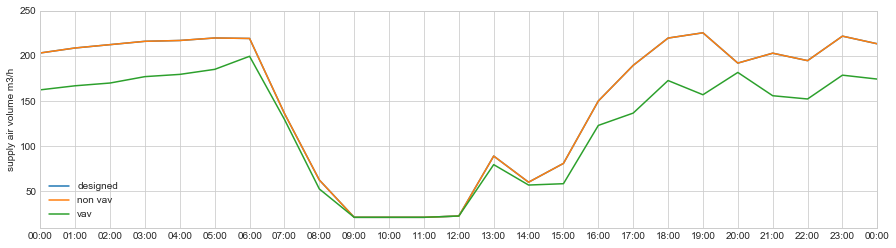

In [94]:
draw_v_supply_h_sample_graph(3)

In [ ]:
draw_v_supply_h_sample_graph(4)

In [ ]:
v_supply_c_sample_nonvav = cs.get_each_supply_air_volume_for_cooling(
    False, q_t_cs, theta_hs_out_c_sample_nonvav, theta_sur, psi, l_duct, c, rho, theta_ac_c, v_vent, v_d_supply)
v_supply_c_sample_vav = cs.get_each_supply_air_volume_for_cooling(
    True, q_t_cs, theta_hs_out_c_sample_vav, theta_sur, psi, l_duct, c, rho, theta_ac_c, v_vent, v_d_supply)

In [ ]:
def draw_v_supply_c_sample_graph(rn):
    ac.draw_graph(y_title='supply air volume m3/h',
                  ys=[(v_d_supply[rn], 'designed'),
                      (v_supply_c_sample_nonvav[rn], 'non vav'),
                      (v_supply_c_sample_vav[rn], 'vav')],
                  op='raw', display_date=cday)

In [ ]:
draw_v_supply_c_sample_graph(0)

In [ ]:
draw_v_supply_c_sample_graph(1)

In [ ]:
draw_v_supply_c_sample_graph(2)

In [ ]:
draw_v_supply_c_sample_graph(3)

In [ ]:
draw_v_supply_c_sample_graph(4)

# 14. ダクト熱損失（参考）

$$ Q_{duct,H,d,t,i} = \left( \theta_{hs,out,H,d,t} - \theta_{sur,H,d,t,i} \right) \left( 1 - \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,H,d,t,i} } \right) \right) c \rho V_{supply,H,d,t,i} 10^{-6} $$

$$ Q_{duct,C,d,t,i} = \left( \theta_{sur,C,d,t,i} - \theta_{hs,out,C,d,t} \right) \left( 1 - \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,C,d,t,i} } \right) \right) c \rho V_{supply,C,d,t,i} 10^{-6} $$

ただし、  
$\sum_{i=0}^5{L'_{H,d,t,i}} = 0$ の場合は $Q_{duct,H,d,t,i} = 0$ とする。  
同様に、$\sum_{i=0}^5{L'_{CS,d,t,i}} = 0$ の場合は $Q_{duct,C,d,t,i} = 0$ とする。

$Q_{duct,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の熱損失, MJ/h  
$Q_{duct,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の熱取得, MJ/h  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{sur,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の周囲の空気温度, ℃  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  

In [ ]:
q_loss_duct_h = cs.get_duct_heat_loss_for_heating(theta_sur, theta_hs_out_h, v_supply_h, theta_ac_h, psi, l_duct, l_d_h)
q_gain_duct_c = cs.get_duct_heat_gain_for_cooling(theta_sur, theta_hs_out_c, v_supply_c, theta_ac_c, psi, l_duct, l_d_cs)

#### VAVの有無がダクト熱損失に与える影響のサンプル

In [ ]:
q_loss_duct_h_sample_nonvav = cs.get_duct_heat_loss_for_heating(
    theta_sur, theta_hs_out_h_sample_nonvav, v_supply_h_sample_nonvav, theta_ac_h, psi, l_duct, l_d_h)
q_loss_duct_h_sample_vav = cs.get_duct_heat_loss_for_heating(
    theta_sur, theta_hs_out_h_sample_vav, v_supply_h_sample_vav, theta_ac_h, psi, l_duct, l_d_h)

In [ ]:
ac.draw_graph(y_title='heat loss, MJ/h',
                  ys=[(np.sum(q_loss_duct_h_sample_nonvav, axis=0), 'non vav'),
                      (np.sum(q_loss_duct_h_sample_vav, axis=0), 'vav')],
                  op='raw', display_date=hday)

In [ ]:
def draw_q_loss_duct_h_sample_graph(rn):
    ac.draw_graph(y_title='heat loss, MJ/h',
                  ys=[(q_loss_duct_h_sample_nonvav[rn], 'non vav'),
                      (q_loss_duct_h_sample_vav[rn], 'vav')],
                  op='raw', display_date=hday)

In [ ]:
draw_q_loss_duct_h_sample_graph(0)

In [ ]:
draw_q_loss_duct_h_sample_graph(1)

In [ ]:
draw_q_loss_duct_h_sample_graph(2)

In [ ]:
draw_q_loss_duct_h_sample_graph(3)

In [ ]:
draw_q_loss_duct_h_sample_graph(4)

In [ ]:
q_gain_duct_c_sample_nonvav = cs.get_duct_heat_gain_for_cooling(
    theta_sur, theta_hs_out_c, v_supply_c_sample_nonvav, theta_ac_c, psi, l_duct, l_d_cs)
q_gain_duct_c_sample_vav = cs.get_duct_heat_gain_for_cooling(
    theta_sur, theta_hs_out_c, v_supply_c_sample_vav, theta_ac_c, psi, l_duct, l_d_cs)

In [ ]:
def draw_q_gain_duct_c_sample_graph(rn):
    ac.draw_graph(y_title='heat gain, MJ/h',
                  ys=[(q_gain_duct_c_sample_nonvav[rn], 'non vav'),
                      (q_gain_duct_c_sample_vav[rn], 'vav')],
                  op='raw', display_date=cday)

In [ ]:
draw_q_gain_duct_c_sample_graph(0)

In [ ]:
draw_q_gain_duct_c_sample_graph(1)

In [ ]:
draw_q_gain_duct_c_sample_graph(2)

In [ ]:
draw_q_gain_duct_c_sample_graph(3)

In [ ]:
draw_q_gain_duct_c_sample_graph(4)

# 15. 吹き出し温度

$$ \theta_{supply,H,d,t,i} = \theta_{sur,H,d,t,i} + \left( \theta_{hs,out,H,d,t} - \theta_{sur,H,d,t,i} \right) \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,H,d,t,i} } \right) $$

$$ \theta_{supply,C,d,t,i} = \theta_{sur,C,d,t,i} + \left( \theta_{hs,out,C,d,t} - \theta_{sur,C,d,t,i} \right) \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,C,d,t,i} } \right) $$

$\theta_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{sur,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  

In [ ]:
theta_supply_h = cs.get_supply_air_temperature_for_heating(theta_sur, theta_hs_out_h, psi, l_duct, v_supply_h)
theta_supply_c = cs.get_supply_air_temperature_for_cooling(theta_sur, theta_hs_out_c, psi, l_duct, v_supply_c)

#### VAVの有無が吹き出し温度に与える影響のサンプル

In [ ]:
theta_supply_h_sample_nonvav = cs.get_supply_air_temperature_for_heating(theta_sur, theta_hs_out_h_sample_nonvav, psi, l_duct, v_supply_h_sample_nonvav)
theta_supply_h_sample_vav = cs.get_supply_air_temperature_for_heating(theta_sur, theta_hs_out_h_sample_vav, psi, l_duct, v_supply_h_sample_vav)

In [ ]:
def draw_theta_supply_h_sample_graph(rn):
    ac.draw_graph(y_title='temperature, degree C',
                  ys=[(theta_supply_h_sample_nonvav[rn], 'non vav'),
                      (theta_supply_h_sample_vav[rn], 'vav')],
                  op='raw', display_date=hday)

In [ ]:
draw_theta_supply_h_sample_graph(0)

In [ ]:
draw_theta_supply_h_sample_graph(1)

In [ ]:
draw_theta_supply_h_sample_graph(2)

In [ ]:
draw_theta_supply_h_sample_graph(3)

In [ ]:
draw_theta_supply_h_sample_graph(4)

In [ ]:
theta_supply_c_sample_nonvav = cs.get_supply_air_temperature_for_cooling(theta_sur, theta_hs_out_c, psi, l_duct, v_supply_c_sample_nonvav)
theta_supply_c_sample_vav = cs.get_supply_air_temperature_for_cooling(theta_sur, theta_hs_out_c, psi, l_duct, v_supply_c_sample_vav)

In [ ]:
def draw_theta_supply_c_sample_graph(rn):
    ac.draw_graph(y_title='temperature, degree C',
                  ys=[(theta_supply_c_sample_nonvav[rn], 'non vav'),
                      (theta_supply_c_sample_vav[rn], 'vav')],
                  op='raw', display_date=cday)

In [ ]:
draw_theta_supply_c_sample_graph(0)

In [ ]:
draw_theta_supply_c_sample_graph(1)

In [ ]:
draw_theta_supply_c_sample_graph(2)

In [ ]:
draw_theta_supply_c_sample_graph(3)

In [ ]:
draw_theta_supply_c_sample_graph(4)

# 16. 暖冷房空間（居室）の温度

$$ \theta_{ac,act,H,d,t,i} = \theta_{ac,H} + \frac{ c \rho V_{supply,H,d,t,i} \left( \theta_{supply,H,d,t,i} - \theta_{ac,H} \right) - Q_{T,H,d,t,i} \times 10^6 }{ c \rho V_{supply,H,d,t,i} + \left( U_{prt} A_{prt,i} + Q A_{HCZ,i} \right) \times 3600 } $$

$$ \theta_{ac,act,C,d,t,i} = \theta_{ac,C} - \frac{ c \rho V_{supply,C,d,t,i} \left( \theta_{ac,C} - \theta_{supply,C,d,t,i} \right) - Q_{T,CS,d,t,i} \times 10^6 }{ c \rho V_{supply,C,d,t,i} + \left( U_{prt} A_{prt,i} + Q A_{HCZ,i} \right) \times 3600 } $$

$\theta_{ac,act,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ の実現温度, ℃    
$\theta_{ac,act,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ の実現温度, ℃  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, ℃    
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, ℃  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$\theta_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し温度, ℃  
$Q_{T,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の処理暖房負荷, MJ/h  
$Q_{T,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の処理冷房顕熱負荷, MJ/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$Q$：熱損失係数, W/m<sup>2</sup>K  

In [ ]:
theta_ac_act_h = cs.get_actual_air_conditioned_temperature_for_heating(
    theta_ac_h, c, rho, v_supply_h, theta_supply_h, q_t_h, u_prt, a_prt, a_hcz, q)
theta_ac_act_c = cs.get_actual_air_conditioned_temperature_for_cooling(
    theta_ac_c, c, rho, v_supply_c, theta_supply_c, q_t_cs, u_prt, a_prt, a_hcz, q)

#### VAVの有無が暖冷房空間（居室）の温度に与える影響のサンプル

In [ ]:
theta_ac_act_h_sample_nonvav = cs.get_actual_air_conditioned_temperature_for_heating(
    theta_ac_h, c, rho, v_supply_h_sample_nonvav, theta_supply_h_sample_nonvav, q_t_h, u_prt, a_prt, a_hcz, q)
theta_ac_act_h_sample_vav = cs.get_actual_air_conditioned_temperature_for_heating(
    theta_ac_h, c, rho, v_supply_h_sample_vav, theta_supply_h_sample_vav, q_t_h, u_prt, a_prt, a_hcz, q)

In [ ]:
def draw_theta_ac_act_h_sample_graph(rn):
    ac.draw_graph(y_title='temperature, degree C',
                  ys=[(theta_ac_act_h_sample_nonvav[rn], 'non vav'),
                      (theta_ac_act_h_sample_vav[rn], 'vav')],
                  op='raw', display_date=hday)

In [ ]:
draw_theta_ac_act_h_sample_graph(0)

In [ ]:
draw_theta_ac_act_h_sample_graph(1)

In [ ]:
draw_theta_ac_act_h_sample_graph(2)

In [ ]:
draw_theta_ac_act_h_sample_graph(3)

In [ ]:
draw_theta_ac_act_h_sample_graph(4)

In [ ]:
theta_ac_act_c_sample_nonvav = cs.get_actual_air_conditioned_temperature_for_cooling(
    theta_ac_c, c, rho, v_supply_c_sample_nonvav, theta_supply_c_sample_nonvav, q_t_cs, u_prt, a_prt, a_hcz, q)
theta_ac_act_c_sample_vav = cs.get_actual_air_conditioned_temperature_for_cooling(
    theta_ac_c, c, rho, v_supply_c_sample_vav, theta_supply_c_sample_vav, q_t_cs, u_prt, a_prt, a_hcz, q)

In [ ]:
def draw_theta_ac_act_c_sample_graph(rn):
    ac.draw_graph(y_title='temperature, degree C',
                  ys=[(theta_ac_act_c_sample_nonvav[rn], 'non vav'),
                      (theta_ac_act_c_sample_vav[rn], 'vav')],
                  op='raw', display_date=cday)

In [ ]:
draw_theta_ac_act_c_sample_graph(0)

In [ ]:
draw_theta_ac_act_c_sample_graph(1)

In [ ]:
draw_theta_ac_act_c_sample_graph(2)

In [ ]:
draw_theta_ac_act_c_sample_graph(3)

In [ ]:
draw_theta_ac_act_c_sample_graph(4)

# 暖冷房空間（居室）の負荷（間仕切りの熱移動を含む）（参考）

$$ L'_{act,H,d,t,i} = \left( \theta_{supply,H,d,t,i} - \theta_{ac,act,H,d,t,i} \right) c \rho V_{supply,H,d,t,i} \times 10^{-6} $$

$$ L'_{act,CS,d,t,i} = \left( \theta_{ac,act,C,d,t,i} - \theta_{supply,C,d,t,i} \right) c \rho V_{supply,C,d,t,i} \times 10^{-6} $$

ただし、  
$\sum_{i=0}^5{L'_{H,d,t,i}} = 0$ の場合は $L'_{act,H,d,t,i} = 0$ とする。  
同様に、$\sum_{i=0}^5{L'_{CS,d,t,i}} = 0$ の場合は $L'_{act,CS,d,t,i} = 0$ とする。

$L'_{act,H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの間仕切り熱損失を含む実際の（※）暖房負荷, MJ/h  
$L'_{act,CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの間仕切り熱取得を含む実際の（※）顕熱冷房負荷, MJ/h  
$\theta_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{ac,act,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ の実現温度, ℃    
$\theta_{ac,act,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ の実現温度, ℃  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
※ 実際の・・・過剰供給によって実現した温度が設定温度よりも高い（暖房時）又は低い（冷房時）影響を考慮した負荷

In [ ]:
l_d_act_h = cs.get_actual_treated_load_for_heating(theta_supply_h, theta_ac_act_h, v_supply_h, l_d_h)
l_d_act_cs = cs.get_actual_treated_load_for_cooling(theta_supply_c, theta_ac_act_c, v_supply_c, l_d_cs)

#### VAVの有無が暖冷房空間（居室）の負荷（間仕切りの熱移動を含む）に与える影響のサンプル

In [ ]:
l_d_act_h_sample_nonvav = cs.get_actual_treated_load_for_heating(
    theta_supply_h_sample_nonvav, theta_ac_act_h_sample_nonvav, v_supply_h_sample_nonvav, l_d_h)
l_d_act_h_sample_vav = cs.get_actual_treated_load_for_heating(
    theta_supply_h_sample_vav, theta_ac_act_h_sample_vav, v_supply_h_sample_vav, l_d_h)

In [ ]:
def draw_l_d_act_h_sample_graph(rn):
    ac.draw_graph(y_title='load, MJ/h',
                  ys=[(l_d_act_h_sample_nonvav[rn], 'non vav'),
                      (l_d_act_h_sample_vav[rn], 'vav'),
                      (l_d_h[rn], 'requested')],
                  op='raw', display_date=hday)

In [ ]:
draw_l_d_act_h_sample_graph(0)

In [ ]:
draw_l_d_act_h_sample_graph(1)

In [ ]:
draw_l_d_act_h_sample_graph(2)

In [ ]:
draw_l_d_act_h_sample_graph(3)

In [ ]:
draw_l_d_act_h_sample_graph(4)

In [ ]:
l_d_act_cs_sample_nonvav = cs.get_actual_treated_load_for_cooling(
    theta_supply_c_sample_nonvav, theta_ac_act_c_sample_nonvav, v_supply_c_sample_nonvav, l_d_cs)
l_d_act_cs_sample_vav = cs.get_actual_treated_load_for_cooling(
    theta_supply_c_sample_vav, theta_ac_act_c_sample_vav, v_supply_c_sample_vav, l_d_cs)

In [ ]:
def draw_l_d_act_cs_sample_graph(rn):
    ac.draw_graph(y_title='load, MJ/h',
                  ys=[(l_d_act_cs_sample_nonvav[rn], 'non vav'),
                      (l_d_act_cs_sample_vav[rn], 'vav'),
                      (l_d_cs[rn], 'requested')],
                  op='raw', display_date=cday)

In [ ]:
draw_l_d_act_cs_sample_graph(0)

In [ ]:
draw_l_d_act_cs_sample_graph(1)

In [ ]:
draw_l_d_act_cs_sample_graph(2)

In [ ]:
draw_l_d_act_cs_sample_graph(3)

In [ ]:
draw_l_d_act_cs_sample_graph(4)

# 非暖冷房空間（非居室）の温度

$$ \theta_{nac,H,d,t} = \frac{ \left( Q \theta_{ex,d,t} + \mu_H J_{d,t} \right) A_{NR} + \sum_{i=1}^5{\left( \left( c \rho \frac{ V_{supply,H,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) \theta_{ac,act,H,d,t,i} \right) } }{ Q A_{NR} + \sum_{i=1}^5{ \left( c \rho \frac{ V_{supply,H,d,t,i} }{ 3600 } + U_{prt} A_{prt,i} \right) } } $$

$$ \theta_{nac,C,d,t} = \frac{ \left( Q \theta_{ex,d,t} + \mu_C J_{d,t} \right) A_{NR} + \sum_{i=1}^5{\left( \left( c \rho \frac{ V_{supply,C,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) \theta_{ac,act,C,d,t,i} \right) } }{ Q A_{NR} + \sum_{i=1}^5{ \left( c \rho \frac{ V_{supply,C,d,t,i} }{ 3600 } + U_{prt}  A_{prt,i} \right) } } $$

$\theta_{nac,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の非暖冷房空間の温度, ℃  
$\theta_{nac,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の非暖冷房空間の温度, ℃  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\theta_{ex,d,t}$：日付 $d$ の時刻 $t$ における外気温度, ℃  
$\mu_H$：暖房期の日射取得係数, （(W/m<sup>2</sup>)/(W/m<sup>2</sup>)）  
$\mu_C$：冷房期の日射取得係数, （(W/m<sup>2</sup>)/(W/m<sup>2</sup>)）  
$J_{d,t}$：日付 $d$ の時刻 $t$ における水平面全天日射量, W/m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$\theta_{ac,act,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ の実現温度, ℃    
$\theta_{ac,act,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ の実現温度, ℃  

In [ ]:
theta_nac_h = cs.get_actual_non_occupant_room_temperature_for_heating(
    theta_ac_h, theta_ac_act_h, v_supply_h, l_h, u_prt, a_prt, q, a_hcz)
theta_nac_c = cs.get_actual_non_occupant_room_temperature_for_cooling(
    q, theta_ex, mu_c, j, a_nr, c, rho, v_supply_c, u_prt, a_prt, theta_ac_act_c)

#### VAVの有無が非暖冷房空間（非居室）の温度に与える影響のサンプル

In [ ]:
theta_nac_h_sample_nonvav = cs.get_actual_non_occupant_room_temperature_for_heating(
    theta_ac_h, theta_ac_act_h_sample_nonvav, v_supply_h_sample_nonvav, l_h, u_prt, a_prt, q, a_hcz)
theta_nac_h_sample_vav = cs.get_actual_non_occupant_room_temperature_for_heating(
    theta_ac_h, theta_ac_act_h_sample_vav, v_supply_h_sample_vav, l_h, u_prt, a_prt, q, a_hcz)

In [ ]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_d_nac, 'designed'),
                  (theta_nac_h_sample_nonvav, 'non vav'),
                  (theta_nac_h_sample_vav, 'vav')],
              op='raw', display_date=hday)

In [ ]:
theta_nac_c_sample_nonvav = cs.get_actual_non_occupant_room_temperature_for_cooling(
    q, theta_ex, mu_c, j, a_nr, c, rho, v_supply_c_sample_nonvav, u_prt, a_prt, theta_ac_act_c_sample_nonvav)
theta_nac_c_sample_vav = cs.get_actual_non_occupant_room_temperature_for_cooling(
    q, theta_ex, mu_c, j, a_nr, c, rho, v_supply_c_sample_vav, u_prt, a_prt, theta_ac_act_c_sample_vav)

In [ ]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_d_nac, 'designed'),
                  (theta_nac_c_sample_nonvav, 'non vav'),
                  (theta_nac_c_sample_vav, 'vav')],
              op='raw', display_date=cday)

# 非暖冷房室（非居室）の負荷（間仕切りの熱移動を含む）（参考）

$$ L'_{act,nac,H,d,t} = \sum_{i=1}^5{\left( \theta_{ac,act,H,d,t,i} - \theta_{nac,H,d,t} \right) c \rho V_{supply,H,d,t,i} \times 10^{-6}} $$

$$ L'_{act,nac,CS,d,t} = \sum_{i=1}^5{\left( \theta_{nac,C,d,t} - \theta_{ac,act,C,d,t,i} \right) c \rho V_{supply,C,d,t,i} \times 10^{-6}} $$

ただし、  
$\sum_{i=0}^5{L'_{H,d,t,i}} = 0$ の場合は $L'_{act,nac,H,d,t} = 0$ とする。  
同様に、$\sum_{i=0}^5{L'_{CS,d,t,i}} = 0$ の場合は $L'_{act,nac,CS,d,t}$ とする。

$L'_{act,nac,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房室の間仕切りの熱移動を含む実際の（※）暖房負荷, MJ/h  
$L'_{act,nac,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房室の間仕切りの熱移動を含む実際の（※）顕熱冷房負荷, MJ/h  
$\theta_{ac,act,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ の実現温度, ℃    
$\theta_{ac,act,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ の実現温度, ℃  
$\theta_{nac,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の非暖冷房空間の温度, ℃  
$\theta_{nac,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の非暖冷房空間の温度, ℃  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h 

In [ ]:
l_d_act_nac_h = cs.get_actual_non_occupant_room_load_for_heating(theta_ac_act_h, theta_nac_h, v_supply_h, l_d_h)
l_d_act_nac_cs = cs.get_actual_non_occupant_room_load_for_cooling(theta_ac_act_c, theta_nac_c, v_supply_c, l_d_cs)

#### VAVの有無が非暖冷房空間（非居室）の負荷に与える影響のサンプル

In [ ]:
l_d_act_nac_h_sample_nonvav = cs.get_actual_non_occupant_room_load_for_heating(
    theta_ac_act_h_sample_nonvav, theta_nac_h_sample_nonvav, v_supply_h_sample_nonvav, l_d_h)
l_d_act_nac_h_sample_vav = cs.get_actual_non_occupant_room_load_for_heating(
    theta_ac_act_h_sample_vav, theta_nac_h_sample_vav, v_supply_h_sample_vav, l_d_h)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(l_d_act_nac_h_sample_nonvav, 'non vav'),
                  (l_d_act_nac_h_sample_vav, 'vav')],
              op='raw', display_date=hday)

In [ ]:
l_d_act_nac_cs_sample_nonvav = cs.get_actual_non_occupant_room_load_for_cooling(
    theta_ac_act_c_sample_nonvav, theta_nac_c_sample_nonvav, v_supply_c_sample_nonvav, l_d_cs)
l_d_act_nac_cs_sample_vav = cs.get_actual_non_occupant_room_load_for_cooling(
    theta_ac_act_c_sample_vav, theta_nac_c_sample_vav, v_supply_c_sample_vav, l_d_cs)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(l_d_act_nac_h_sample_nonvav, 'non vav'),
                  (l_d_act_nac_h_sample_vav, 'vav')],
              op='raw', display_date=hday)

# 暖冷房室（居室）と非暖冷房室（非居室）との熱移動（参考）

$$ Q_{trs,prt,H,d,t,i} = U_{prt} A_{prt,i} \left( \theta_{ac,act,H,d,t,i} - \theta_{nac,H,d,t} \right) \times 3600 \times 10^{-6} $$

$$ Q_{trs,prt,C,d,t,i} = U_{prt} A_{prt,i} \left( \theta_{nac,C,d,t} - \theta_{ac,act,C,d,t,i} \right) \times 3600 \times 10^{-6} $$

ただし、  
$\sum_{i=0}^5{L'_{H,d,t,i}} = 0$ の場合は $Q_{trs,prt,H,d,t,i} = 0$ とする。  
同様に、$\sum_{i=0}^5{L'_{CS,d,t,i}} = 0$ の場合は $Q_{trs,prt,C,d,t,i} = 0$ とする。


$Q_{trs,prt,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ から非暖冷房空間への貫流熱損失, MJ/h  
$Q_{trs,prt,C,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房空間から暖冷房区画 $i$ への貫流熱取得, MJ/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$\theta_{ac,act,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ の実現温度, ℃    
$\theta_{ac,act,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ の実現温度, ℃  
$\theta_{nac,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の非暖冷房空間の温度, ℃  
$\theta_{nac,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の非暖冷房空間の温度, ℃  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  

In [ ]:
q_trs_prt_h = cs.get_actual_heat_loss_through_partition_for_heating(u_prt, a_prt, theta_ac_act_h, theta_nac_h, l_d_h)
q_trs_prt_c = cs.get_actual_heat_gain_through_partition_for_cooling(u_prt, a_prt, theta_ac_act_c, theta_nac_c, l_d_cs)

#### VAVの有無が暖冷房室と非暖冷房室との熱移動に与える影響のサンプル

In [ ]:
q_trs_prt_h_sample_nonvav = cs.get_actual_heat_loss_through_partition_for_heating(
    u_prt, a_prt, theta_ac_act_h_sample_nonvav, theta_nac_h_sample_nonvav, l_d_h)
q_trs_prt_h_sample_vav = cs.get_actual_heat_loss_through_partition_for_heating(
    u_prt, a_prt, theta_ac_act_h_sample_vav, theta_nac_h_sample_vav, l_d_h)

In [ ]:
q_trs_prt_c_sample_nonvav = cs.get_actual_heat_gain_through_partition_for_cooling(
    u_prt, a_prt, theta_ac_act_c_sample_nonvav, theta_nac_c_sample_nonvav, l_d_cs)
q_trs_prt_c_sample_vav = cs.get_actual_heat_gain_through_partition_for_cooling(
    u_prt, a_prt, theta_ac_act_c_sample_vav, theta_nac_c_sample_vav, l_d_cs)

# 熱源機入り口温度

$$ \theta_{hs,in,H,d,t} = \theta_{nac,H,d,t} $$

$$ \theta_{hs,in,H,d,t} = \theta_{nac,H,d,t} $$

$\theta_{hs,in,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機入り口温度, ℃  
$\theta_{hs,in,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機入り口温度, ℃  
$\theta_{nac,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の非暖冷房空間の温度, ℃  
$\theta_{nac,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の非暖冷房空間の温度, ℃  

In [ ]:
theta_hs_in_h = cs.get_heat_source_inlet_air_temperature_for_heating(theta_nac_h)
theta_hs_in_c = cs.get_heat_source_inlet_air_temperature_for_cooling(theta_nac_c)

#### VAVの有無が熱源機入り口温度に与える影響のサンプル

In [ ]:
theta_hs_in_h_sample_nonvav = cs.get_heat_source_inlet_air_temperature_for_heating(theta_nac_h_sample_nonvav)
theta_hs_in_h_sample_vav = cs.get_heat_source_inlet_air_temperature_for_heating(theta_nac_h_sample_vav)

In [ ]:
theta_hs_in_c_sample_nonvav = cs.get_heat_source_inlet_air_temperature_for_cooling(theta_nac_c_sample_nonvav)
theta_hs_in_c_sample_vav = cs.get_heat_source_inlet_air_temperature_for_cooling(theta_nac_c_sample_vav)

# 熱源機処理熱量（参考）

$$ Q_{hs,H,d,t} = \left( \theta_{hs,out,H,d,t} - \theta_{hs,in,H,d,t} \right) c \rho \sum_{i=1}^5{V_{supply,H,d,t,i}} \times 10^{-6} $$

$$ Q_{hs,CS,d,t} = \left( \theta_{hs,in,C,d,t} - \theta_{hs,out,C,d,t} \right) c \rho \sum_{i=1}^5{V_{supply,C,d,t,i}} \times 10^{-6} $$

$$ Q_{hs,CL,d,t} = \sum_{i=1}^5{Q_{T,CL,d,t,i}} $$ 

ただし、  
$\sum_{i=0}^5{L'_{H,d,t,i}} = 0$ の場合は $Q_{hs,H,d,t} = 0$ とする。  
同様に、$\sum_{i=0}^5{L'_{CS,d,t,i}} = 0$ の場合は $Q_{hs,CS,d,t} = 0$ 、  
$\sum_{i=0}^5{L'_{CL,d,t,i}} = 0$ の場合は $Q_{hs,CL,d,t} = 0$ とする。

$Q_{hs,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の暖房出力, MJ/h  
$Q_{hs,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房顕熱出力, MJ/h  
$Q_{hs,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房潜熱出力, MJ/h  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\theta_{hs,in,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の入口空気温度, ℃  
$\theta_{hs,in,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の入口空気温度, ℃  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$Q_{T,CL,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の処理冷房潜熱負荷, MJ/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  

In [ ]:
q_hs_h = cs.get_heat_source_heating_output(theta_hs_out_h, theta_hs_in_h, v_supply_h, l_d_h)
q_hs_cs, q_hs_cl = cs.get_heat_source_cooling_output(theta_hs_in_c, theta_hs_out_c, v_supply_c, l_cl, l_d_cs)

#### VAVの有無が熱源機処理負荷に与える影響のサンプル

In [ ]:
q_hs_h_sample_nonvav = cs.get_heat_source_heating_output(theta_hs_out_h_sample_nonvav, theta_hs_in_h_sample_nonvav, v_supply_h_sample_nonvav, l_d_h)
q_hs_h_sample_vav = cs.get_heat_source_heating_output(theta_hs_out_h_sample_vav, theta_hs_in_h_sample_vav, v_supply_h_sample_vav, l_d_h)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(l_d_act_h_sample_vav[rn], 'vav'),
                  (l_d_h[rn], 'requested')],
              op='raw', display_date=hday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(q_hs_h_sample_nonvav, 'non vav'),
                  (q_hs_h_sample_vav, 'vav')],
              op='raw', display_date=hday)

In [ ]:
q_hs_cs_sample_nonvav, q_hs_cl_sample_nonvav = cs.get_heat_source_cooling_output(
    theta_hs_in_c_sample_nonvav, theta_hs_out_c, v_supply_c_sample_nonvav, l_cl, l_d_cs)
q_hs_cs_sample_vav, q_hs_cl_sample_vav = cs.get_heat_source_cooling_output(
    theta_hs_in_c_sample_vav, theta_hs_out_c, v_supply_c_sample_vav, l_cl, l_d_cs)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(q_hs_cs_sample_nonvav, 'non vav'),
                  (q_hs_cs_sample_vav, 'vav')],
              op='raw', display_date=cday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(q_hs_cl_sample_nonvav, 'non vav'),
                  (q_hs_cl_sample_vav, 'vav')],
              op='raw', display_date=cday)

# 考察

## 年間負荷および従来の負荷との比較

### 暖房負荷

In [ ]:
ac.draw_graph(y_title='load, MJ/d',
              ys=[(q_hs_h_sample_nonvav, 'non vav'),
                  (q_hs_h_sample_vav, 'vav'),
                  (np.sum(l_h[0:5], axis=0), 'old 1-5'),
                  (np.sum(l_h, axis=0), 'old')],
              op='itg')

### 顕熱冷房負荷

In [ ]:
ac.draw_graph(y_title='load, MJ/d',
              ys=[(q_hs_cs_sample_nonvav, 'non vav'),
                  (q_hs_cs_sample_vav, 'vav'),
                  (np.sum(l_cs[0:5], axis=0), 'old 1-5'),
                  (np.sum(l_cs, axis=0), 'old')],
              op='itg')

### 潜熱冷房負荷

In [ ]:
ac.draw_graph(y_title='load, MJ/d',
              ys=[(q_hs_cl_sample_nonvav, 'non vav'),
                  (q_hs_cl_sample_vav, 'vav'),
                  (np.sum(l_cl[0:5], axis=0), 'old 1-5'),
                  (np.sum(l_cl, axis=0), 'old')],
              op='itg')

## 居室の負荷

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_h_sample_vav - q_trs_prt_h_sample_vav, axis=0), 'vav'),
                  (np.sum(l_d_act_h_sample_nonvav - q_trs_prt_h_sample_nonvav, axis=0), 'nonvav'),
                  (np.sum(l_h[0:5], axis=0), 'old'),
                  (np.sum(q_ut_h, axis=0), 'untreated')
              ],
              op='raw', display_date=hday)

### 暖房負荷

In [ ]:
def draw_actual_heating_load_in_occupant_rooms_graph(rn):
    ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (l_d_act_h_sample_vav[rn] - q_trs_prt_h_sample_vav[rn], 'vav'),
                  (l_d_act_h_sample_nonvav[rn] - q_trs_prt_h_sample_nonvav[rn], 'nonvav'),
                  (l_h[rn], 'old'),
                  (q_ut_h[rn], 'untreated')
              ],
              op='raw', display_date=hday)

In [ ]:
draw_actual_heating_load_in_occupant_rooms_graph(0)

In [ ]:
draw_actual_heating_load_in_occupant_rooms_graph(1)

In [ ]:
draw_actual_heating_load_in_occupant_rooms_graph(2)

In [ ]:
draw_actual_heating_load_in_occupant_rooms_graph(3)

In [ ]:
draw_actual_heating_load_in_occupant_rooms_graph(4)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_h_sample_vav - q_trs_prt_h_sample_vav, axis=0), 'vav'),
                  (np.sum(l_d_act_h_sample_nonvav - q_trs_prt_h_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_h[0:5], axis=0), 'old'),
                  (np.sum(q_ut_h, axis=0), 'untreated'),
              ],
              op='raw', display_date=hday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_h_sample_vav - q_trs_prt_h_sample_vav, axis=0), 'vav'),
                  (np.sum(l_d_act_h_sample_nonvav - q_trs_prt_h_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_h[0:5], axis=0), 'old'),
                  (np.sum(q_ut_h, axis=0), 'untreated'),
              ],
              op='itg')

### 顕熱冷房負荷

In [ ]:
def draw_actual_sensible_cooling_load_in_occupant_rooms_graph(rn):
    ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (l_d_act_cs_sample_vav[rn] - q_trs_prt_c_sample_vav[rn], 'vav'),
                  (l_d_act_cs_sample_nonvav[rn] - q_trs_prt_c_sample_nonvav[rn], 'nonvav'),
                  (l_cs[rn], 'old'),
                  (q_ut_cs[rn], 'untreated'),
              ],
              op='raw', display_date=cday)

In [ ]:
draw_actual_sensible_cooling_load_in_occupant_rooms_graph(0)

In [ ]:
draw_actual_sensible_cooling_load_in_occupant_rooms_graph(1)

In [ ]:
draw_actual_sensible_cooling_load_in_occupant_rooms_graph(2)

In [ ]:
draw_actual_sensible_cooling_load_in_occupant_rooms_graph(3)

In [ ]:
draw_actual_sensible_cooling_load_in_occupant_rooms_graph(4)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_cs_sample_vav - q_trs_prt_c_sample_vav, axis=0), 'vav'),
                  (np.sum(l_d_act_cs_sample_nonvav - q_trs_prt_c_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_cs[0:5], axis=0), 'old'),
                  (np.sum(q_ut_cs, axis=0), 'untreated'),
              ],
              op='raw', display_date=cday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_cs_sample_vav - q_trs_prt_c_sample_vav, axis=0), 'vav'),
                  (np.sum(l_d_act_cs_sample_nonvav - q_trs_prt_c_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_cs[0:5], axis=0), 'old'),
                  (np.sum(q_ut_cs, axis=0), 'untreated'),
              ],
              op='itg')

## 非居室の負荷

### 暖房負荷

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (l_d_act_nac_h_sample_vav + np.sum(q_trs_prt_h_sample_vav, axis=0), 'vav'),
                  (l_d_act_nac_h_sample_nonvav + np.sum(q_trs_prt_h_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_h[5:12], axis=0), 'old'),
              ],
              op='raw', display_date=hday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (l_d_act_nac_h_sample_vav + np.sum(q_trs_prt_h_sample_vav, axis=0), 'vav'),
                  (l_d_act_nac_h_sample_nonvav + np.sum(q_trs_prt_h_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_h[5:12], axis=0), 'old')
              ],
              op='itg')

### 顕熱冷房負荷

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (l_d_act_nac_cs_sample_vav + np.sum(q_trs_prt_c_sample_vav, axis=0), 'vav'),
                  (l_d_act_nac_cs_sample_nonvav + np.sum(q_trs_prt_c_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_cs[5:12], axis=0), 'old'),
              ],
              op='raw', display_date=cday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (l_d_act_nac_cs_sample_vav + np.sum(q_trs_prt_c_sample_vav, axis=0), 'vav'),
                  (l_d_act_nac_cs_sample_nonvav + np.sum(q_trs_prt_c_sample_nonvav, axis=0), 'non vav'),
                  (np.sum(l_cs[5:12], axis=0), 'old'),
              ],
              op='itg')

## 暖冷房室と非暖冷房室の合計負荷の比較

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_h_sample_vav, axis=0) + l_d_act_nac_h_sample_vav, 'vav'),
                  (np.sum(l_d_act_h_sample_nonvav, axis=0) + l_d_act_nac_h_sample_nonvav, 'non vav'),
                  (np.sum(l_h, axis=0), 'old'),
                  (np.sum(q_ut_h, axis=0), 'untreated')
              ],
              op='itg')

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_cs_sample_vav, axis=0) + l_d_act_nac_cs_sample_vav, 'vav'),
                  (np.sum(l_d_act_cs_sample_nonvav, axis=0) + l_d_act_nac_cs_sample_nonvav, 'non vav'),
                  (np.sum(l_cs, axis=0), 'old'),
                  (np.sum(q_ut_cs, axis=0), 'untreated')
              ],
              op='itg')

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_cl, axis=0), 'vav & non vav'),
                  (np.sum(l_cl, axis=0), 'old'),
                  (np.sum(q_ut_cl, axis=0), 'untreated')
              ],
              op='itg')

## 処理熱量の比較

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_h_sample_nonvav- q_trs_prt_h_sample_nonvav, axis=0), 'occupant'),
                  (np.sum(l_d_act_h_sample_vav- q_trs_prt_h_sample_vav, axis=0), 'occupant vav'),
                  (np.sum(l_h[0:5], axis=0), 'occupant old room 1-5'),
                  (np.sum(l_d_act_h_sample_nonvav, axis=0)+l_d_act_nac_h_sample_nonvav, 'occupant + non occupant'),
                  (np.sum(l_d_act_h_sample_vav, axis=0)+l_d_act_nac_h_sample_vav, 'occupant + non occupant vav'),
                  (np.sum(l_h,axis=0),'occupant + non occupant old room 1-12'),
                  (q_hs_h_sample_nonvav, 'occupant + non occupant + duct loss'),
                  (q_hs_h_sample_vav, 'occupant + non occupant + duct loss vav'),
                  (np.sum(q_ut_h, axis=0), 'untreated'),
              ],
              op='raw', display_date=hday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_h_sample_nonvav- q_trs_prt_h_sample_nonvav, axis=0), 'occupant'),
                  (np.sum(l_d_act_h_sample_vav- q_trs_prt_h_sample_vav, axis=0), 'occupant vav'),
                  (np.sum(l_h[0:5], axis=0), 'occupant old room 1-5'),
                  (np.sum(l_d_act_h_sample_nonvav, axis=0)+l_d_act_nac_h_sample_nonvav, 'occupant + non occupant'),
                  (np.sum(l_d_act_h_sample_vav, axis=0)+l_d_act_nac_h_sample_vav, 'occupant + non occupant vav'),
                  (np.sum(l_h,axis=0),'occupant + non occupant old room 1-12'),
                  (q_hs_h_sample_nonvav, 'occupant + non occupant + duct loss'),
                  (q_hs_h_sample_vav, 'occupant + non occupant + duct loss vav'),
                  (np.sum(q_ut_h, axis=0), 'untreated'),
              ],
              op='itg')

In [ ]:
(np.sum(l_h),np.sum(q_hs_h_sample_nonvav),np.sum(q_hs_h_sample_vav))

In [ ]:
(np.sum(l_cs),np.sum(q_hs_cs_sample_nonvav),np.sum(q_hs_cs_sample_vav))

In [ ]:
(np.sum(l_cl),np.sum(q_hs_cl_sample_nonvav),np.sum(q_hs_cl_sample_vav))

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_cs_sample_nonvav - q_trs_prt_c_sample_nonvav, axis=0), 'occupant'),
                  (np.sum(l_d_act_cs_sample_vav - q_trs_prt_c_sample_vav, axis=0), 'occupant vav'),
                  (np.sum(l_cs[0:5], axis=0), 'occupant old room 1-5'),
                  (np.sum(l_d_act_cs_sample_nonvav, axis=0) + l_d_act_nac_cs_sample_nonvav, 'occupant + non occupant'),
                  (np.sum(l_d_act_cs_sample_vav, axis=0) + l_d_act_nac_cs_sample_vav, 'occupant + non occupant vav'),
                  (np.sum(l_cs, axis=0),'occupant + non occupant old room 1-12'),
                  (q_hs_cs_sample_nonvav, 'occupant + non occupant + duct loss'),
                  (q_hs_cs_sample_vav, 'occupant + non occupant + duct loss vav'),
                  (np.sum(q_ut_cs, axis=0), 'untreated'),
              ],
              op='raw', display_date=cday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_act_cs_sample_nonvav - q_trs_prt_c_sample_nonvav, axis=0), 'occupant'),
                  (np.sum(l_d_act_cs_sample_vav - q_trs_prt_c_sample_vav, axis=0), 'occupant vav'),
                  (np.sum(l_cs[0:5], axis=0), 'occupant old room 1-5'),
                  (np.sum(l_d_act_cs_sample_nonvav, axis=0) + l_d_act_nac_cs_sample_nonvav, 'occupant + non occupant'),
                  (np.sum(l_d_act_cs_sample_vav, axis=0) + l_d_act_nac_cs_sample_vav, 'occupant + non occupant vav'),
                  (np.sum(l_cs, axis=0),'occupant + non occupant old room 1-12'),
                  (q_hs_cs_sample_nonvav, 'occupant + non occupant + duct loss'),
                  (q_hs_cs_sample_vav, 'occupant + non occupant + duct loss vav'),
                  (np.sum(q_ut_cs, axis=0), 'untreated'),
              ],
              op='itg')

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_cl, axis=0), 'new'),
                  (np.sum(l_cl[0:5], axis=0), 'occupant old room 1-5'),
                  (np.sum(l_cl, axis=0),'occupant + non occupant old room 1-12'),
                  (np.sum(q_ut_cl, axis=0), 'untreated'),
              ],
              op='raw', display_date=cday)

In [ ]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[
                  (np.sum(l_d_cl, axis=0), 'new'),
                  (np.sum(l_cl[0:5], axis=0), 'occupant old room 1-5'),
                  (np.sum(l_cl, axis=0),'occupant + non occupant old room 1-12'),
                  (np.sum(q_ut_cl, axis=0), 'untreated'),
              ],
              op='itg')